### RNN with LSTM cell
* Architecture reference from https://arxiv.org/pdf/2004.00959.pdf
* Country-specific network

(Something new: Maybe decrease number of classifier by grouping countries in the same GDP/ bracket)

#### Data partition
* Test data is the last 10 days
* Validation 10 days before last 10 days
* Data logged

In [1]:
import torch
import pandas as pd
import numpy as np
import os
import copy
#import writer
import random
from sklearn.preprocessing import normalize
#import 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [2]:
# read data in
csse_country = "CPSC540_Covid/active_data/csse_world_normalized.csv"
df_csse = pd.read_csv(csse_country)
df_csse.head(10)
#list(df_csse.columns.values.tolist()) 
countries = df_csse["Country/Region"].tolist()

In [3]:
countries
df_csse.shape

(171, 81)

#### What if use grouping from k-means? or hierarchical clustering to decide which countries are in the same bracket


In [4]:
validation_d = 5
test_d = 5

# Convert to numpy array

cases = df_csse.loc[:,'1/22/20':]
casesA = cases.to_numpy()
casesA
count, days = casesA.shape

print(days)
# last 10 days for test

case_test = casesA[:,-test_d:]
case_validation = casesA[:,days-validation_d-test_d:days-test_d]
case_train = casesA[:,:days-validation_d-test_d]

print(case_test.shape)
print(case_validation.shape)
print(case_train.shape)

79
(171, 5)
(171, 5)
(171, 69)


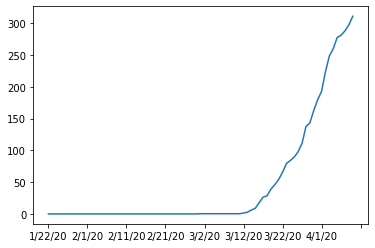

In [5]:
# plot 
#epoch = np.linspace(1, len(trainErr), len(trainErr))

cases.loc[50,:].plot.line()


In [6]:
case_train

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.41700405e+01, 1.82186235e+01, 1.82186235e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.69184222e+00, 3.38368444e+00, 3.38368444e+00],
       ...,
       [3.02112385e-03, 3.02112385e-03, 6.04224770e-03, ...,
        3.66960808e+02, 4.25703540e+02, 4.88911494e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.91862032e+05, 1.91862032e+05, 1.91862032e+05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.77039570e+02, 9.77039570e+02, 9.77039570e+02]])

In [7]:
# log transform
case_test_log = np.log(case_test)
case_validation_log = np.log(case_validation)
case_train_log = np.log(case_train)
case_train_log

/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


array([[       -inf,        -inf,        -inf, ...,        -inf,
               -inf,        -inf],
       [       -inf,        -inf,        -inf, ...,  2.65112991,
         2.90244434,  2.90244434],
       [       -inf,        -inf,        -inf, ...,  0.52581801,
         1.21896519,  1.21896519],
       ...,
       [-5.80212638, -5.80212638, -5.1089792 , ...,  5.90525505,
         6.05374319,  6.19218148],
       [       -inf,        -inf,        -inf, ..., 12.16453181,
        12.16453181, 12.16453181],
       [       -inf,        -inf,        -inf, ...,  6.88452715,
         6.88452715,  6.88452715]])

### Divide data into training sets
* specify number of days for train and prediction
* offset the dataset so for example: [1,2,3,4] then get [1,2],[2,3] which predicts 3 and 4 respectively

In [8]:
# test 
np.array(case_train[3,:])
#total_days-pred_days-t_days

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00869841, 0.00869841, 0.00869841, 0.04349203,
       0.04349203, 0.05219044, 0.05219044, 0.07828566, 0.07828566,
       0.09568248, 0.09568248, 0.10438088, 0.10438088, 0.10438088,
       0.13917451, 0.13917451, 0.18266655, 0.20006336])

In [9]:
t_days = 40
pred_days = test_d
total_days = case_train.shape[1]

country_train_X = []
country_train_Y = []

country_valid_X = []
country_valid_Y = []

country_test_X = []
country_test_Y = []


for i in range(len(countries)):
    # split dataset
    cur_c = [] # current country 
    out = []
    
    cur_v = [] # current country 
    out_v = []
    
    cur_t = [] # current country 
    out_t = []
    
    for j in range(total_days-pred_days-t_days): 
        
        #print(j)
        #print(case_train[i,j:j+t_days].shape)
        #print(len(case_train[i,j+t_days]))
        cur_c.append(case_train[i,j:j+t_days])
        #print(str(j))
        out.append(case_train[i,j+t_days:j+t_days+pred_days])
        #print(len(cur_c))
    
    country_train_X.append(cur_c)
    country_train_Y.append(out)
    
    country_valid_X.append(case_train[i,-t_days:])
    country_valid_Y.append(case_validation[i])
    
    country_test_X.append(casesA[i,days-test_d-t_days:days-test_d])
    country_test_Y.append(case_test[i])


In [10]:
# check dimension

#len(country_test_X[33])
total_days-pred_days-test_d
pred_days
test_d
total_days
case_train[0,29:64].shape
case_train[0,0:40].shape

(40,)

In [11]:
len(country_train_X[1])
len(country_train_Y[1])
len(country_train_Y[1][0])
#len(country_test_Y[1])
#a = torch.tensor(country_train_X[10]).unsqueeze_(1).unsqueeze_(1)
#torch.max(torch.tensor(country_train_X[2])).item()
#torch.randn(a.shape[0],a.shape[1],a.shape[2])*0.05
#a+a

5

#### Data size & index
The first axis is the sequence itself, the second indexes instances in the mini-batch, and the third indexes elements of the input. We haven’t discussed mini-batching, so lets just ignore that and assume we will always have just 1 dimension on the second axis.

In [12]:
#import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

### Optimized hyperparameters
|Parameter |Description|Distribution/Selection|Values|
|----------|------------|----------------------|---------|
|Learning rate|Minimum learning rate| Log uniform|1e-1 to 1e-7|
|Hidden layers|Number of layers in the network|Discrete numeric|1 to 20|
|Hidden state|Number of memory cell in each layer|Discrete numeric|1 to 200|
|Activation|Activation in each layer|Category|{ReLu,sigmoid,tanh}|
|Batch size|Batch size during training|Discrete numeric|1 to 10|
|Dropout|Dropout size before dense layer|Log uniform|0 to 0.|

In [13]:
# Parameter
num_epochs = 30 # max
batch_size = 1
# Loss and optimizer
criterion = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
learning_rate = 0.01 # to be changed/optimized 
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
output_directory = "mock/"
output_file_path = "mock/Train"
input_dim = t_days
hidden_dim = 2
hidden_state = 100
output_dim= pred_days
num_layers=2
lstm_input_size = t_days
#model = LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)

model_name = "mock"
output_file_path = "./outputs/" + model_name + "/training/"
directory = os.path.dirname(output_file_path)
if not os.path.exists(directory):
    print("Creating directory %s" % output_file_path)
    os.makedirs(directory)
else:
     print("Directory %s exists" % output_file_path)


Directory ./outputs/mock/training/ exists


In [14]:
# RNN structure

class RNN(nn.Module):

    # you can also accept arguments in your model constructor
    def __init__(self, data_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        input_size = data_size + hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, data, last_hidden):
        input = torch.cat((data, last_hidden), 1)
        hidden = self.i2h(input)
        output = self.h2o(hidden)
        return hidden, output
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [15]:
# LSTM structure

class LSTM(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=pred_days,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
 
        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers,dropout=0)
 
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)
 
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
 
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        
        return y_pred.view(-1)

#model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)

In [16]:
# training function
def train_model(train_loader, test_loader, model, device, criterion, optimizer, num_epochs, output_directory,learning_rate,hidden_dim,num_layers):
    
    total_step = len(train_loader)
    model.train()
    model.hidden = model.init_hidden() # LSTM hidden reinitialization
    
    #open files to log error
    train_error = open(output_directory + "training_error"+ "_"+str(learning_rate)+ "_"+ str(hidden_dim) + "_"+ str(num_layers) +".txt", "a")
    test_error = open(output_directory + "validation_error"+ "_"+str(learning_rate)+ "_"+ str(hidden_dim) + "_"+ str(num_layers) +".txt", "a")

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_loss_valid = float('inf')
    best_epoch = 1

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (seqs, labels) in enumerate(train_loader):
            #print(seqs.shape)
            # add gaussian noise to sequence
            noiselevel = torch.max(torch.tensor(country_train_X[2])).item()/1000
            noise = torch.randn(seqs.shape[0],seqs.shape[1],seqs.shape[2],seqs.shape[3])*noiselevel
            #print(noise.shape)
            seqs += noise # add gaussian noise
            #print(seqs.shape)
            seqs = seqs.to(device)
            labels = labels.to(device)

            # Forward pass
            #seqs = seqs.squeeze()
            #print(seqs.shape)
            #print(model(seqs))
            outputs = model(seqs) # error 
            loss = criterion(outputs, labels) # change input to 
            running_loss += loss.item()
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #if (i+1) % 100 == 0:
            #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
            #           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        #save training loss to file
        epoch_loss = running_loss / len(train_loader.dataset)
        print("%s, %s" % (epoch, epoch_loss), file=train_error)
        
        #calculate test loss for epoch
        test_loss = 0.0
        with torch.no_grad():
            model.eval()
            for i, (seqs, labels) in enumerate(test_loader):
                x = seqs.to(device)
                y = labels.to(device)
                outputs = model(x)
                #print(outputs.shape)
                #print(y.shape)
                loss = criterion(outputs, y)
                test_loss += loss.item() 
                
                # for metrics
                #updateYlist(outputs,y)
                

        test_loss = te1e-05, 30, 1st_loss / len(test_loader.dataset)
        
        #save outputs for epoch
        print("%s, %s" % (epoch, test_loss), file=test_error)
        
        # for each epoch, calculate metrics (f1, pr)
        #calculateMetrics(outputs,y)
        
        if test_loss < best_loss_valid:
            best_loss_valid = test_loss
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            print ('Saving the best model weights at Epoch [{}], Best Valid Loss: {:.4f}' 
                       .format(epoch+1, best_loss_valid))

        
    train_error.close()
    test_error.close()

    #model.load_state_dict(best_model_wts)
    print("train error:", epoch_loss)
    return model, best_loss_valid


In [17]:
def test_model(test_loader, model, device,criterion):
    #predictions = torch.zeros(0, numClass)
    test_loss = 0.0
    
    with torch.no_grad():
        model.eval()
        for i, (seqs, labels) in enumerate(test_loader):            
            seqs = seqs.to(device)
            y = labels.to(device).float()
            print(y)
            pred = model(seqs).float()
            print(pred)
            loss = criterion(pred, y)
            test_loss += loss.item() 
            
    return pred,test_loss

In [18]:
#dimension check
a = torch.tensor(country_train_X[0]).unsqueeze_(2).unsqueeze_(2) #torch.Size([19, 30, 1, 1])
torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).shape
torch.tensor(country_valid_Y[0]).unsqueeze_(0).shape
#torch.tensor(country_train_Y[0])
torch.tensor(country_train_X[0])
a.size(-1)
torch.tensor(country_test_Y[0]).unsqueeze_(0).shape
torch.tensor(country_valid_Y[0]).unsqueeze_(0).shape
torch.tensor(country_train_Y[0]).unsqueeze_(1).shape
#torch.tensor(country_valid_Y[0]).unsqueeze_(0).unsqueeze_(0).shape
torch.tensor(country_train_Y[0]).unsqueeze_(1).shape
torch.tensor(country_valid_Y[0]).unsqueeze_(0).shape
torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).shape
torch.tensor(country_train_X[0]).unsqueeze_(2).unsqueeze_(2).shape
torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).shape

torch.Size([1, 40, 1, 1])

In [19]:
# test if it runs
learning_rate = 0.01 # to be changed/optimized 
num_layers = 2
hidden_dim = 100

net =  LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)
print(net)
model = net.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)

train_dataset = torch.utils.data.TensorDataset(torch.tensor(country_train_X[0]).unsqueeze_(2).unsqueeze_(2).float(), torch.tensor(country_train_Y[0]).unsqueeze_(1).float())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# load validation
valid_dataset = torch.utils.data.TensorDataset(torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_valid_Y[0]).unsqueeze_(0).float())
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

# load test
test_dataset = torch.utils.data.TensorDataset(torch.tensor(country_test_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_test_Y[0]).unsqueeze_(0).float())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# mock trial
err = train_model(train_loader, valid_loader, model, device, criterion,  optimizer, num_epochs, output_file_path,learning_rate,hidden_dim, num_layers)



LSTM(
  (lstm): LSTM(40, 100, num_layers=2)
  (linear): Linear(in_features=100, out_features=5, bias=True)
)


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Saving the best model weights at Epoch [1], Best Valid Loss: 0.0484
train error: 6.7692523542930635e-12


In [20]:
torch.tensor(country_train_Y[0]).unsqueeze_(0).shape


torch.Size([1, 24, 5])

In [ ]:
# optimization grid
lr_list = [0.1,0.01,0.001,0.005,1e-4,5e-4,1e-5,1e-6]
hidden_lst = [1,2,3,4,5]
hState_lst savefig(fname= [30,50,100,200,300]

country_result = dict()
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
best_error = 1e10

for i in range(len(countries)):
    country_result[countries[i]] = [] # store best validation parameter, test loss, test result
    best_error = 1e10
    
    best_param = [0,0,0]

    learning_rate = lr_list[0] # to be changed/optimized 
    hidden_dim = hidden_lst[0]
    hidden_state = hState_lst[0]
    
    
    model_name = countries[i]
    output_file_path = "./offline/" + model_name + "/training/"
    directory = os.path.dirname(output_file_path)
    if not os.path.exists(directory):
        print("Creating directory %s" % output_file_path)
        os.makedirs(directory)
    else:
         print("Directory %s exists" % output_file_path)

    
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(country_train_X[i]).unsqueeze_(2).unsqueeze_(2).float(), torch.tensor(country_train_Y[i]).unsqueeze_(1).float())
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    # load validation
    valid_dataset = torch.utils.data.TensorDataset(torch.tensor(country_valid_X[i]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_valid_Y[i]).unsqueeze_(0).float())
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

    # load test
    test_dataset = torch.utils.data.TensorDataset(torch.tensor(country_test_X[i]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_test_Y[i]).unsqueeze_(0).float())
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    bestmodel = 0
    
    # optimize (learning rate, hidden layer, hidden state, activation)
    for j in range(len(lr_list)):
        for k in range(len(hidden_lst)): # hidden layer
            for m in range(len(hState_lst)): # hidden state
                # train
                # specific parameters
                learning_rate = lr_list[j]
                hidden_dim = hState_lst[m]
                num_layers = hidden_lst[k]
                
                net =  LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)
                #print(net)
                model = net.to(device)
                
                #
                optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
                # to be changed/optimized 
                
                model, err = train_model(train_loader, valid_loader, model, device, criterion,  optimizer, num_epochs, output_file_path,learning_rate,hidden_dim,num_layers)
                print(err)
                if err < best_error:
                    best_error = err
                    best_param = [lr_list[j],hidden_lst[k],hState_lst[m]]
                    bestmodel = model
    
    country_result[countries[i]].append(best_param)
    
    # test data
    pred,final_loss = test_model(test_loader,bestmodel,device,criterion)
    print("test loss: ",final_loss)
    country_result[countries[i]].append([pred.tolist(),country_test_Y[i].tolist()])
    country_result[countries[i]].append(final_loss)
    torch.save(bestmodel.state_dict(), output_file_path+countries[i]+".th")
    print("%s, %s" % (epoch, epoch_loss), file=train_error)

Directory ./outputs/Burundi/training/ exists
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0501
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0477
train error: 1.2224617261756092e-09
0.04767756909132004
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0498
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0494
train error: 3.541498357594042e-10
0.049432095140218735
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0493
train error: 2.5686448685650437e-10
0.049295779317617416
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0500
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0487
train error: 1.1491109431181756e-10
0.04872298240661621
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0494
train error: 8.300809974277901e-11
0.0493806600570

Saving the best model weights at Epoch [3], Best Valid Loss: 0.0489
train error: 3.914692726149739e-17
0.04894004389643669
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0467
train error: 3.313604262530599e-17
0.04665930196642876
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0510
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0494
train error: 2.6179417088225853e-17
0.04944324493408203
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0464
train error: 1.771061195445542e-17
0.0464303158223629
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0623
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0604
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0587
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0573
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0561
Saving the best model weights at

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0508
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0506
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0505
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0503
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0502
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0501
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0501
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0500
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0500
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0498
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0498
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.0498
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0498
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [51], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [52], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [53], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [54], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [55], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [56], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [57], Best Valid Loss: 0.0496
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [51], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [52], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [53], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [54], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [55], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [56], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [57], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [58], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [59], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [60], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [61], Best Valid Loss: 0.0495
Saving the best model weights at E

Saving the best model weights at Epoch [68], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [69], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [70], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [71], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [72], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [73], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [74], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [75], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [76], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [77], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [78], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [79], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [80], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [81], Best Valid Loss: 0.0495
Saving the best model weights at E

Saving the best model weights at Epoch [85], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [86], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [87], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [88], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [89], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [90], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [91], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [92], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [93], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [94], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [95], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [97], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [98], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [99], Best Valid Loss: 0.0495
Saving the best model weights at E

Saving the best model weights at Epoch [95], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [96], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [97], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [98], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [99], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [100], Best Valid Loss: 0.0495
train error: 3.1722979007119817e-12
0.049508821219205856
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0741
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0711
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0684
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0661
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0641
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0624
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0609
Saving the best model weights at Epoch [8], Best Val

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0524
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0521
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0518
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0516
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0514
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0512
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0510
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0508
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0507
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0506
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0503
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0503
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0502
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 0.0498
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0496
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [51], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [52], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [53], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [54], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [55], Best Valid Loss: 0.0495
Saving the best model weights at E

Saving the best model weights at Epoch [62], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [63], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [64], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [65], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [66], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [67], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [68], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [69], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [70], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [71], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [72], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [73], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [74], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [75], Best Valid Loss: 0.0495
Saving the best model weights at E

Saving the best model weights at Epoch [82], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [83], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [86], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [87], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [88], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [92], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [98], Best Valid Loss: 0.0495
train error: 2.3518571711072154e-12
0.0495082326233387
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0448
train error: 2.759431974188517e-13
0.04483025148510933
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0478
train error: 5.006396185562473e-13
0.047771479934453964
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0490
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0475
train error: 8.459216093807213e-10
0.04747023060917854
Saving the best model we

Saving the best model weights at Epoch [7], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0495
Saving the best model weights at Epoc

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0495
train error: 2.537012133888433e-16
0.0495082326233387
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0565
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0530
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0512
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0503
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [6], Best Valid

Saving the best model weights at Epoch [88], Best Valid Loss: 0.0587
Saving the best model weights at Epoch [89], Best Valid Loss: 0.0586
Saving the best model weights at Epoch [90], Best Valid Loss: 0.0585
Saving the best model weights at Epoch [91], Best Valid Loss: 0.0584
Saving the best model weights at Epoch [92], Best Valid Loss: 0.0583
Saving the best model weights at Epoch [93], Best Valid Loss: 0.0582
Saving the best model weights at Epoch [94], Best Valid Loss: 0.0580
Saving the best model weights at Epoch [95], Best Valid Loss: 0.0579
Saving the best model weights at Epoch [96], Best Valid Loss: 0.0578
Saving the best model weights at Epoch [97], Best Valid Loss: 0.0577
Saving the best model weights at Epoch [98], Best Valid Loss: 0.0576
Saving the best model weights at Epoch [99], Best Valid Loss: 0.0575
Saving the best model weights at Epoch [100], Best Valid Loss: 0.0574
train error: 0.0017328808559492852
0.057415544986724854
Saving the best model weights at Epoch [1], Be

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0581
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0580
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0579
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0578
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0577
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0576
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0575
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0574
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0573
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0572
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0571
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0570
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0568
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.0511
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0511
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0511
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0510
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0510
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0510
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0509
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0509
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0509
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0509
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0508
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0508
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0508
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0508
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.0515
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0515
Saving the best model weights at Epoch [51], Best Valid Loss: 0.0515
Saving the best model weights at Epoch [52], Best Valid Loss: 0.0515
Saving the best model weights at Epoch [53], Best Valid Loss: 0.0514
Saving the best model weights at Epoch [54], Best Valid Loss: 0.0514
Saving the best model weights at Epoch [55], Best Valid Loss: 0.0514
Saving the best model weights at Epoch [56], Best Valid Loss: 0.0514
Saving the best model weights at Epoch [57], Best Valid Loss: 0.0513
Saving the best model weights at Epoch [58], Best Valid Loss: 0.0513
Saving the best model weights at Epoch [59], Best Valid Loss: 0.0513
Saving the best model weights at Epoch [60], Best Valid Loss: 0.0513
Saving the best model weights at Epoch [61], Best Valid Loss: 0.0513
Saving the best model weights at Epoch [62], Best Valid Loss: 0.0512
Saving the best model weights at E

Saving the best model weights at Epoch [12], Best Valid Loss: 0.0479
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0479
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0479
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0479
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0479
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0479
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0479
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0478
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0478
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0478
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0478
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0478
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0478
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0478
Saving the best model weights at E

train error: 0.0004393177769088652
0.032824140042066574
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0443
train error: 0.0001646349525496286
0.044297732412815094
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1317
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1307
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1296
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1286
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1275
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1265
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1256
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1246
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1236
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1227
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1217
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1208
S

Saving the best model weights at Epoch [18], Best Valid Loss: 0.0582
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0581
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0580
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0578
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0577
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0576
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0575
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0574
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0573
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0572
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0570
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0568
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0567
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.0558
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0557
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0556
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0555
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0555
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0554
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0553
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0553
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0552
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0551
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0551
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0550
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0549
Saving the best model weights at Epoch [51], Best Valid Loss: 0.0549
Saving the best model weights at E

Saving the best model weights at Epoch [59], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [60], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [61], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [62], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [63], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [64], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [65], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [66], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [67], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [68], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [69], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [70], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [71], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [72], Best Valid Loss: 0.0499
Saving the best model weights at E

Saving the best model weights at Epoch [81], Best Valid Loss: 0.0531
Saving the best model weights at Epoch [82], Best Valid Loss: 0.0530
Saving the best model weights at Epoch [83], Best Valid Loss: 0.0530
Saving the best model weights at Epoch [84], Best Valid Loss: 0.0529
Saving the best model weights at Epoch [85], Best Valid Loss: 0.0529
Saving the best model weights at Epoch [86], Best Valid Loss: 0.0529
Saving the best model weights at Epoch [87], Best Valid Loss: 0.0528
Saving the best model weights at Epoch [88], Best Valid Loss: 0.0528
Saving the best model weights at Epoch [89], Best Valid Loss: 0.0528
Saving the best model weights at Epoch [90], Best Valid Loss: 0.0527
Saving the best model weights at Epoch [91], Best Valid Loss: 0.0527
Saving the best model weights at Epoch [92], Best Valid Loss: 0.0527
Saving the best model weights at Epoch [93], Best Valid Loss: 0.0526
Saving the best model weights at Epoch [94], Best Valid Loss: 0.0526
Saving the best model weights at E

Saving the best model weights at Epoch [100], Best Valid Loss: 0.0481
train error: 0.0018111430836142972
0.04813796281814575
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0447
train error: 0.0006268280097477449
0.04469873011112213
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0601
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0599
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0598
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0597
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0596
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0595
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0594
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0593
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0591
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0590
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0589
Sa

Saving the best model weights at Epoch [17], Best Valid Loss: 0.0539
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0539
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0538
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0538
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0537
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0536
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0536
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0535
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0535
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0534
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0534
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0533
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0533
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0532
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.0505
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0505
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0505
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0503
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0503
Saving the best model weights at E

Saving the best model weights at Epoch [57], Best Valid Loss: 0.0547
Saving the best model weights at Epoch [58], Best Valid Loss: 0.0546
Saving the best model weights at Epoch [59], Best Valid Loss: 0.0545
Saving the best model weights at Epoch [60], Best Valid Loss: 0.0544
Saving the best model weights at Epoch [61], Best Valid Loss: 0.0543
Saving the best model weights at Epoch [62], Best Valid Loss: 0.0542
Saving the best model weights at Epoch [63], Best Valid Loss: 0.0542
Saving the best model weights at Epoch [64], Best Valid Loss: 0.0541
Saving the best model weights at Epoch [65], Best Valid Loss: 0.0540
Saving the best model weights at Epoch [66], Best Valid Loss: 0.0539
Saving the best model weights at Epoch [67], Best Valid Loss: 0.0539
Saving the best model weights at Epoch [68], Best Valid Loss: 0.0538
Saving the best model weights at Epoch [69], Best Valid Loss: 0.0537
Saving the best model weights at Epoch [70], Best Valid Loss: 0.0536
Saving the best model weights at E

Saving the best model weights at Epoch [77], Best Valid Loss: 0.0542
Saving the best model weights at Epoch [78], Best Valid Loss: 0.0541
Saving the best model weights at Epoch [79], Best Valid Loss: 0.0541
Saving the best model weights at Epoch [80], Best Valid Loss: 0.0540
Saving the best model weights at Epoch [81], Best Valid Loss: 0.0540
Saving the best model weights at Epoch [82], Best Valid Loss: 0.0539
Saving the best model weights at Epoch [83], Best Valid Loss: 0.0539
Saving the best model weights at Epoch [84], Best Valid Loss: 0.0538
Saving the best model weights at Epoch [85], Best Valid Loss: 0.0538
Saving the best model weights at Epoch [86], Best Valid Loss: 0.0537
Saving the best model weights at Epoch [87], Best Valid Loss: 0.0537
Saving the best model weights at Epoch [88], Best Valid Loss: 0.0536
Saving the best model weights at Epoch [89], Best Valid Loss: 0.0536
Saving the best model weights at Epoch [90], Best Valid Loss: 0.0536
Saving the best model weights at E

Saving the best model weights at Epoch [96], Best Valid Loss: 0.0518
Saving the best model weights at Epoch [97], Best Valid Loss: 0.0518
Saving the best model weights at Epoch [98], Best Valid Loss: 0.0517
Saving the best model weights at Epoch [99], Best Valid Loss: 0.0517
Saving the best model weights at Epoch [100], Best Valid Loss: 0.0517
train error: 0.0005724851653212681
0.05169117450714111
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0614
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0613
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0611
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0610
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0609
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0608
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0606
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0605
Saving the best model weights at Epoch [9], Best Valid 

Saving the best model weights at Epoch [16], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0496
Saving the best model weights at E

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0549
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0546
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0543
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0540
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0538
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0535
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0533
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0531
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0529
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0527
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0525
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0523
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0522
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0520
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0496
Saving the best model weights at E

Saving the best model weights at Epoch [53], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [54], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [55], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [56], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [57], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [58], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [59], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [60], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [61], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [62], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [63], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [64], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [65], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [66], Best Valid Loss: 0.0496
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [51], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [52], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [53], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [54], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [55], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [56], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [57], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [58], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [59], Best Valid Loss: 0.0495
Saving the best model weights at E

Saving the best model weights at Epoch [93], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [94], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [95], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [96], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [97], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [98], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [99], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [100], Best Valid Loss: 0.0495
train error: 5.640715997993576e-08
0.04954889789223671
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0579
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0574
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0565
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0561
Saving the best model weights at Epoch [6], Best Val

Saving the best model weights at Epoch [12], Best Valid Loss: 0.0507
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0506
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0506
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0505
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0503
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0503
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0502
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0502
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0502
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0501
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0501
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0501
Saving the best model weights at E

Saving the best model weights at Epoch [20], Best Valid Loss: 0.0542
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0540
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0537
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0535
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0533
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0531
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0529
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0527
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0525
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0523
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0522
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0520
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0519
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0518
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.0513
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0512
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0511
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0510
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0509
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0509
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0508
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0507
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0507
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0506
Saving the best model weights at Epoch [51], Best Valid Loss: 0.0505
Saving the best model weights at Epoch [52], Best Valid Loss: 0.0505
Saving the best model weights at Epoch [53], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [54], Best Valid Loss: 0.0504
Saving the best model weights at E

Saving the best model weights at Epoch [61], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [62], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [63], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [64], Best Valid Loss: 0.0498
Saving the best model weights at Epoch [65], Best Valid Loss: 0.0498
Saving the best model weights at Epoch [66], Best Valid Loss: 0.0498
Saving the best model weights at Epoch [67], Best Valid Loss: 0.0498
Saving the best model weights at Epoch [68], Best Valid Loss: 0.0498
Saving the best model weights at Epoch [69], Best Valid Loss: 0.0498
Saving the best model weights at Epoch [70], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [71], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [72], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [73], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [74], Best Valid Loss: 0.0497
Saving the best model weights at E

Saving the best model weights at Epoch [81], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [82], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [83], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [84], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [85], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [86], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [87], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [88], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [89], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [90], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [91], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [92], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [93], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [94], Best Valid Loss: 0.0495
Saving the best model weights at E

Saving the best model weights at Epoch [63], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [64], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [65], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [66], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [67], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [68], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [69], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [70], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [71], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [72], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [73], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [74], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [75], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [76], Best Valid Loss: 0.0496
Saving the best model weights at E

Saving the best model weights at Epoch [86], Best Valid Loss: 0.0880
Saving the best model weights at Epoch [87], Best Valid Loss: 0.0880
Saving the best model weights at Epoch [88], Best Valid Loss: 0.0879
Saving the best model weights at Epoch [89], Best Valid Loss: 0.0879
Saving the best model weights at Epoch [90], Best Valid Loss: 0.0878
Saving the best model weights at Epoch [91], Best Valid Loss: 0.0878
Saving the best model weights at Epoch [92], Best Valid Loss: 0.0877
Saving the best model weights at Epoch [93], Best Valid Loss: 0.0877
Saving the best model weights at Epoch [94], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [95], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [96], Best Valid Loss: 0.0875
Saving the best model weights at Epoch [97], Best Valid Loss: 0.0875
Saving the best model weights at Epoch [98], Best Valid Loss: 0.0875
Saving the best model weights at Epoch [99], Best Valid Loss: 0.0874
Saving the best model weights at E

train error: 0.0011219966302936275
0.04255983978509903
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0494
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0494
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0494
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0494
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0494
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0494
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0494
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0494
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0494
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0494
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0494
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0494
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0494
Saving the best model weights at Epoch [14], Best Valid L

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0586
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0585
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0585
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0585
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0585
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0585
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0584
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0584
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0584
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0584
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0584
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0583
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0583
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0583
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.0576
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0576
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0576
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0576
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0575
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0575
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0575
Saving the best model weights at Epoch [51], Best Valid Loss: 0.0575
Saving the best model weights at Epoch [52], Best Valid Loss: 0.0575
Saving the best model weights at Epoch [53], Best Valid Loss: 0.0575
Saving the best model weights at Epoch [54], Best Valid Loss: 0.0575
Saving the best model weights at Epoch [55], Best Valid Loss: 0.0575
Saving the best model weights at Epoch [56], Best Valid Loss: 0.0574
Saving the best model weights at Epoch [57], Best Valid Loss: 0.0574
Saving the best model weights at E

Saving the best model weights at Epoch [64], Best Valid Loss: 0.0528
Saving the best model weights at Epoch [65], Best Valid Loss: 0.0528
Saving the best model weights at Epoch [66], Best Valid Loss: 0.0528
Saving the best model weights at Epoch [67], Best Valid Loss: 0.0528
Saving the best model weights at Epoch [68], Best Valid Loss: 0.0528
Saving the best model weights at Epoch [69], Best Valid Loss: 0.0528
Saving the best model weights at Epoch [70], Best Valid Loss: 0.0528
Saving the best model weights at Epoch [71], Best Valid Loss: 0.0528
Saving the best model weights at Epoch [72], Best Valid Loss: 0.0528
Saving the best model weights at Epoch [73], Best Valid Loss: 0.0528
Saving the best model weights at Epoch [74], Best Valid Loss: 0.0528
Saving the best model weights at Epoch [75], Best Valid Loss: 0.0528
Saving the best model weights at Epoch [76], Best Valid Loss: 0.0527
Saving the best model weights at Epoch [77], Best Valid Loss: 0.0527
Saving the best model weights at E

Saving the best model weights at Epoch [84], Best Valid Loss: 0.0516
Saving the best model weights at Epoch [85], Best Valid Loss: 0.0516
Saving the best model weights at Epoch [86], Best Valid Loss: 0.0516
Saving the best model weights at Epoch [87], Best Valid Loss: 0.0516
Saving the best model weights at Epoch [88], Best Valid Loss: 0.0516
Saving the best model weights at Epoch [89], Best Valid Loss: 0.0516
Saving the best model weights at Epoch [90], Best Valid Loss: 0.0515
Saving the best model weights at Epoch [91], Best Valid Loss: 0.0515
Saving the best model weights at Epoch [92], Best Valid Loss: 0.0515
Saving the best model weights at Epoch [93], Best Valid Loss: 0.0515
Saving the best model weights at Epoch [94], Best Valid Loss: 0.0515
Saving the best model weights at Epoch [95], Best Valid Loss: 0.0515
Saving the best model weights at Epoch [96], Best Valid Loss: 0.0515
Saving the best model weights at Epoch [97], Best Valid Loss: 0.0515
Saving the best model weights at E

Saving the best model weights at Epoch [3], Best Valid Loss: 0.0678
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0678
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0677
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0677
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0677
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0676
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0676
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0676
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0676
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0675
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0675
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0675
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0675
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0674
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0495
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0535
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0535
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0535
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0535
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0535
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0535
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0534
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0534
Saving the best model weights at Epoch [51], Best Valid Loss: 0.0534
Saving the best model weights at Epoch [52], Best Valid Loss: 0.0534
Saving the best model weights at Epoch [53], Best Valid Loss: 0.0534
Saving the best model weights at Epoch [54], Best Valid Loss: 0.0534
Saving the best model weights at Epoch [55], Best Valid Loss: 0.0534
Saving the best model weights at Epoch [56], Best Valid Loss: 0.0534
Saving the best model weights at E

Saving the best model weights at Epoch [63], Best Valid Loss: 0.0543
Saving the best model weights at Epoch [64], Best Valid Loss: 0.0543
Saving the best model weights at Epoch [65], Best Valid Loss: 0.0543
Saving the best model weights at Epoch [66], Best Valid Loss: 0.0543
Saving the best model weights at Epoch [67], Best Valid Loss: 0.0543
Saving the best model weights at Epoch [68], Best Valid Loss: 0.0543
Saving the best model weights at Epoch [69], Best Valid Loss: 0.0543
Saving the best model weights at Epoch [70], Best Valid Loss: 0.0543
Saving the best model weights at Epoch [71], Best Valid Loss: 0.0543
Saving the best model weights at Epoch [72], Best Valid Loss: 0.0543
Saving the best model weights at Epoch [73], Best Valid Loss: 0.0543
Saving the best model weights at Epoch [74], Best Valid Loss: 0.0542
Saving the best model weights at Epoch [75], Best Valid Loss: 0.0542
Saving the best model weights at Epoch [76], Best Valid Loss: 0.0542
Saving the best model weights at E

Saving the best model weights at Epoch [85], Best Valid Loss: 0.0755
Saving the best model weights at Epoch [86], Best Valid Loss: 0.0755
Saving the best model weights at Epoch [87], Best Valid Loss: 0.0754
Saving the best model weights at Epoch [88], Best Valid Loss: 0.0754
Saving the best model weights at Epoch [89], Best Valid Loss: 0.0754
Saving the best model weights at Epoch [90], Best Valid Loss: 0.0753
Saving the best model weights at Epoch [91], Best Valid Loss: 0.0753
Saving the best model weights at Epoch [92], Best Valid Loss: 0.0752
Saving the best model weights at Epoch [93], Best Valid Loss: 0.0752
Saving the best model weights at Epoch [94], Best Valid Loss: 0.0752
Saving the best model weights at Epoch [95], Best Valid Loss: 0.0751
Saving the best model weights at Epoch [96], Best Valid Loss: 0.0751
Saving the best model weights at Epoch [97], Best Valid Loss: 0.0751
Saving the best model weights at Epoch [98], Best Valid Loss: 0.0750
Saving the best model weights at E

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0651
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0650
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0650
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0650
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0650
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0649
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0649
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0649
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0649
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0649
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0648
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0648
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0648
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0648
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [24], Best Valid Loss: 0.0557
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0557
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0557
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0557
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0557
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0557
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0557
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0557
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0557
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0557
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0557
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0557
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0556
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0556
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.0600
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0600
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0600
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0600
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0599
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0599
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0599
Saving the best model weights at Epoch [51], Best Valid Loss: 0.0599
Saving the best model weights at Epoch [52], Best Valid Loss: 0.0599
Saving the best model weights at Epoch [53], Best Valid Loss: 0.0599
Saving the best model weights at Epoch [54], Best Valid Loss: 0.0599
Saving the best model weights at Epoch [55], Best Valid Loss: 0.0599
Saving the best model weights at Epoch [56], Best Valid Loss: 0.0599
Saving the best model weights at Epoch [57], Best Valid Loss: 0.0598
Saving the best model weights at E

Saving the best model weights at Epoch [65], Best Valid Loss: 0.0788
Saving the best model weights at Epoch [66], Best Valid Loss: 0.0788
Saving the best model weights at Epoch [67], Best Valid Loss: 0.0787
Saving the best model weights at Epoch [68], Best Valid Loss: 0.0787
Saving the best model weights at Epoch [69], Best Valid Loss: 0.0786
Saving the best model weights at Epoch [70], Best Valid Loss: 0.0786
Saving the best model weights at Epoch [71], Best Valid Loss: 0.0786
Saving the best model weights at Epoch [72], Best Valid Loss: 0.0785
Saving the best model weights at Epoch [73], Best Valid Loss: 0.0785
Saving the best model weights at Epoch [74], Best Valid Loss: 0.0784
Saving the best model weights at Epoch [75], Best Valid Loss: 0.0784
Saving the best model weights at Epoch [76], Best Valid Loss: 0.0784
Saving the best model weights at Epoch [77], Best Valid Loss: 0.0783
Saving the best model weights at Epoch [78], Best Valid Loss: 0.0783
Saving the best model weights at E

Saving the best model weights at Epoch [85], Best Valid Loss: 0.0630
Saving the best model weights at Epoch [86], Best Valid Loss: 0.0629
Saving the best model weights at Epoch [87], Best Valid Loss: 0.0629
Saving the best model weights at Epoch [88], Best Valid Loss: 0.0629
Saving the best model weights at Epoch [89], Best Valid Loss: 0.0629
Saving the best model weights at Epoch [90], Best Valid Loss: 0.0629
Saving the best model weights at Epoch [91], Best Valid Loss: 0.0628
Saving the best model weights at Epoch [92], Best Valid Loss: 0.0628
Saving the best model weights at Epoch [93], Best Valid Loss: 0.0628
Saving the best model weights at Epoch [94], Best Valid Loss: 0.0628
Saving the best model weights at Epoch [95], Best Valid Loss: 0.0628
Saving the best model weights at Epoch [96], Best Valid Loss: 0.0628
Saving the best model weights at Epoch [97], Best Valid Loss: 0.0627
Saving the best model weights at Epoch [98], Best Valid Loss: 0.0627
Saving the best model weights at E

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0554
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0553
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0553
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0553
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0553
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0553
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0553
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0553
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0553
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0553
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0553
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0553
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0553
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0553
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0892
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0892
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0892
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0892
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0892
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0891
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0891
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0891
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0891
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0891
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0891
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0891
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0891
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0891
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [51], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [52], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [53], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [54], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [55], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [56], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [57], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [58], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [59], Best Valid Loss: 0.0493
Saving the best model weights at E

Saving the best model weights at Epoch [97], Best Valid Loss: 0.0459
Saving the best model weights at Epoch [98], Best Valid Loss: 0.0459
Saving the best model weights at Epoch [100], Best Valid Loss: 0.0459
train error: 0.00345841224770993
0.04594679921865463
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0745
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0745
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0745
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0745
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0745
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0745
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0745
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0745
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0745
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0745
Saving the best model weights at Epoch [11], Best Valid Lo

Saving the best model weights at Epoch [16], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0436
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0569
Saving the best model weights at E

Saving the best model weights at Epoch [56], Best Valid Loss: 0.0521
Saving the best model weights at Epoch [57], Best Valid Loss: 0.0521
Saving the best model weights at Epoch [58], Best Valid Loss: 0.0521
Saving the best model weights at Epoch [59], Best Valid Loss: 0.0521
Saving the best model weights at Epoch [60], Best Valid Loss: 0.0521
Saving the best model weights at Epoch [61], Best Valid Loss: 0.0521
Saving the best model weights at Epoch [62], Best Valid Loss: 0.0521
Saving the best model weights at Epoch [63], Best Valid Loss: 0.0521
Saving the best model weights at Epoch [64], Best Valid Loss: 0.0521
Saving the best model weights at Epoch [65], Best Valid Loss: 0.0521
Saving the best model weights at Epoch [66], Best Valid Loss: 0.0521
Saving the best model weights at Epoch [67], Best Valid Loss: 0.0521
Saving the best model weights at Epoch [68], Best Valid Loss: 0.0521
Saving the best model weights at Epoch [69], Best Valid Loss: 0.0521
Saving the best model weights at E

Saving the best model weights at Epoch [76], Best Valid Loss: 0.0555
Saving the best model weights at Epoch [77], Best Valid Loss: 0.0555
Saving the best model weights at Epoch [78], Best Valid Loss: 0.0555
Saving the best model weights at Epoch [79], Best Valid Loss: 0.0555
Saving the best model weights at Epoch [80], Best Valid Loss: 0.0555
Saving the best model weights at Epoch [81], Best Valid Loss: 0.0555
Saving the best model weights at Epoch [82], Best Valid Loss: 0.0555
Saving the best model weights at Epoch [83], Best Valid Loss: 0.0555
Saving the best model weights at Epoch [84], Best Valid Loss: 0.0555
Saving the best model weights at Epoch [85], Best Valid Loss: 0.0555
Saving the best model weights at Epoch [86], Best Valid Loss: 0.0555
Saving the best model weights at Epoch [87], Best Valid Loss: 0.0555
Saving the best model weights at Epoch [88], Best Valid Loss: 0.0555
Saving the best model weights at Epoch [89], Best Valid Loss: 0.0555
Saving the best model weights at E

Saving the best model weights at Epoch [97], Best Valid Loss: 0.0356
Saving the best model weights at Epoch [98], Best Valid Loss: 0.0356
Saving the best model weights at Epoch [99], Best Valid Loss: 0.0356
Saving the best model weights at Epoch [100], Best Valid Loss: 0.0356
train error: 0.020646104977155726
0.03562804311513901
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0438
train error: 0.0011519754043547437
0.04379094019532204
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0666
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0666
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0666
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0666
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0666
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0666
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0666
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0666
Sa

Saving the best model weights at Epoch [11], Best Valid Loss: 0.0519
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0519
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0519
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0519
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0519
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0519
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0519
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0519
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0519
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0519
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0519
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0519
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0519
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0519
Saving the best model weights at E

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0496
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0877
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0877
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0877
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [51], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [52], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [53], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [54], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [55], Best Valid Loss: 0.0876
Saving the best model weights at E

Saving the best model weights at Epoch [61], Best Valid Loss: 0.0525
Saving the best model weights at Epoch [62], Best Valid Loss: 0.0525
Saving the best model weights at Epoch [63], Best Valid Loss: 0.0525
Saving the best model weights at Epoch [64], Best Valid Loss: 0.0525
Saving the best model weights at Epoch [65], Best Valid Loss: 0.0525
Saving the best model weights at Epoch [66], Best Valid Loss: 0.0525
Saving the best model weights at Epoch [67], Best Valid Loss: 0.0525
Saving the best model weights at Epoch [68], Best Valid Loss: 0.0525
Saving the best model weights at Epoch [69], Best Valid Loss: 0.0525
Saving the best model weights at Epoch [70], Best Valid Loss: 0.0525
Saving the best model weights at Epoch [71], Best Valid Loss: 0.0525
Saving the best model weights at Epoch [72], Best Valid Loss: 0.0525
Saving the best model weights at Epoch [73], Best Valid Loss: 0.0525
Saving the best model weights at Epoch [74], Best Valid Loss: 0.0525
Saving the best model weights at E

Saving the best model weights at Epoch [78], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [79], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [80], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [81], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [82], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [83], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [84], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [85], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [86], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [87], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [88], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [89], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [90], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [91], Best Valid Loss: 0.0569
Saving the best model weights at E

Saving the best model weights at Epoch [5], Best Valid Loss: 1297.3815
Saving the best model weights at Epoch [16], Best Valid Loss: 1285.7948
Saving the best model weights at Epoch [58], Best Valid Loss: 1285.2889
train error: 19.295544881373644
1285.2889404296875
Saving the best model weights at Epoch [1], Best Valid Loss: 1560.0731
Saving the best model weights at Epoch [2], Best Valid Loss: 1402.1490
Saving the best model weights at Epoch [4], Best Valid Loss: 1304.0121
Saving the best model weights at Epoch [6], Best Valid Loss: 1286.7090
Saving the best model weights at Epoch [36], Best Valid Loss: 1170.7227
Saving the best model weights at Epoch [37], Best Valid Loss: 1061.6458
Saving the best model weights at Epoch [39], Best Valid Loss: 1054.4768
train error: 8.125155583024025
1054.476806640625
Saving the best model weights at Epoch [1], Best Valid Loss: 1431.0172
Saving the best model weights at Epoch [3], Best Valid Loss: 1296.4823
Saving the best model weights at Epoch [17]

train error: 0.18995911094437665
731.111572265625
Saving the best model weights at Epoch [1], Best Valid Loss: 1634.9574
Saving the best model weights at Epoch [2], Best Valid Loss: 1550.5470
Saving the best model weights at Epoch [3], Best Valid Loss: 1543.1761
Saving the best model weights at Epoch [4], Best Valid Loss: 1439.9006
Saving the best model weights at Epoch [5], Best Valid Loss: 1234.0870
Saving the best model weights at Epoch [6], Best Valid Loss: 899.2555
Saving the best model weights at Epoch [7], Best Valid Loss: 862.5803
Saving the best model weights at Epoch [9], Best Valid Loss: 806.6032
Saving the best model weights at Epoch [13], Best Valid Loss: 769.7829
Saving the best model weights at Epoch [17], Best Valid Loss: 759.9102
Saving the best model weights at Epoch [21], Best Valid Loss: 759.5050
Saving the best model weights at Epoch [22], Best Valid Loss: 744.7742
Saving the best model weights at Epoch [24], Best Valid Loss: 738.7516
Saving the best model weights 

Saving the best model weights at Epoch [5], Best Valid Loss: 1553.1758
Saving the best model weights at Epoch [10], Best Valid Loss: 1534.0262
Saving the best model weights at Epoch [11], Best Valid Loss: 1470.9980
Saving the best model weights at Epoch [12], Best Valid Loss: 1179.1918
Saving the best model weights at Epoch [13], Best Valid Loss: 913.5280
Saving the best model weights at Epoch [14], Best Valid Loss: 776.8550
Saving the best model weights at Epoch [23], Best Valid Loss: 722.0229
Saving the best model weights at Epoch [32], Best Valid Loss: 717.1468
Saving the best model weights at Epoch [33], Best Valid Loss: 708.5038
Saving the best model weights at Epoch [34], Best Valid Loss: 698.6965
Saving the best model weights at Epoch [82], Best Valid Loss: 698.4354
train error: 0.44853433502915624
698.4353637695312
Saving the best model weights at Epoch [1], Best Valid Loss: 1652.3990
Saving the best model weights at Epoch [2], Best Valid Loss: 1553.0247
Saving the best model w

Saving the best model weights at Epoch [11], Best Valid Loss: 1195.1669
Saving the best model weights at Epoch [12], Best Valid Loss: 1140.0262
Saving the best model weights at Epoch [13], Best Valid Loss: 1066.5446
Saving the best model weights at Epoch [14], Best Valid Loss: 1030.7369
Saving the best model weights at Epoch [15], Best Valid Loss: 1000.9518
Saving the best model weights at Epoch [16], Best Valid Loss: 970.5331
Saving the best model weights at Epoch [17], Best Valid Loss: 937.1998
Saving the best model weights at Epoch [18], Best Valid Loss: 919.5041
Saving the best model weights at Epoch [19], Best Valid Loss: 900.1554
Saving the best model weights at Epoch [20], Best Valid Loss: 882.3185
Saving the best model weights at Epoch [21], Best Valid Loss: 878.2827
Saving the best model weights at Epoch [22], Best Valid Loss: 858.8091
Saving the best model weights at Epoch [23], Best Valid Loss: 850.2487
Saving the best model weights at Epoch [24], Best Valid Loss: 841.0509
S

Saving the best model weights at Epoch [37], Best Valid Loss: 718.1032
Saving the best model weights at Epoch [38], Best Valid Loss: 716.7355
Saving the best model weights at Epoch [40], Best Valid Loss: 714.0844
Saving the best model weights at Epoch [41], Best Valid Loss: 711.2148
Saving the best model weights at Epoch [42], Best Valid Loss: 708.9077
Saving the best model weights at Epoch [43], Best Valid Loss: 707.5706
Saving the best model weights at Epoch [44], Best Valid Loss: 706.6006
Saving the best model weights at Epoch [46], Best Valid Loss: 703.6371
Saving the best model weights at Epoch [47], Best Valid Loss: 702.6729
Saving the best model weights at Epoch [48], Best Valid Loss: 701.6717
Saving the best model weights at Epoch [50], Best Valid Loss: 699.6470
Saving the best model weights at Epoch [53], Best Valid Loss: 696.9450
Saving the best model weights at Epoch [54], Best Valid Loss: 695.2006
Saving the best model weights at Epoch [55], Best Valid Loss: 694.1171
Saving

Saving the best model weights at Epoch [3], Best Valid Loss: 1624.0643
Saving the best model weights at Epoch [4], Best Valid Loss: 1574.9774
Saving the best model weights at Epoch [5], Best Valid Loss: 1480.2161
Saving the best model weights at Epoch [6], Best Valid Loss: 1397.7588
Saving the best model weights at Epoch [7], Best Valid Loss: 1258.7834
Saving the best model weights at Epoch [8], Best Valid Loss: 1156.1921
Saving the best model weights at Epoch [9], Best Valid Loss: 996.7125
Saving the best model weights at Epoch [10], Best Valid Loss: 895.9049
Saving the best model weights at Epoch [11], Best Valid Loss: 751.4597
Saving the best model weights at Epoch [12], Best Valid Loss: 673.8903
Saving the best model weights at Epoch [13], Best Valid Loss: 604.4629
Saving the best model weights at Epoch [14], Best Valid Loss: 552.2673
Saving the best model weights at Epoch [15], Best Valid Loss: 493.7463
Saving the best model weights at Epoch [16], Best Valid Loss: 461.1719
Saving 

Saving the best model weights at Epoch [98], Best Valid Loss: 271.0711
Saving the best model weights at Epoch [100], Best Valid Loss: 270.5669
train error: 1.153996804729104
270.56689453125
Saving the best model weights at Epoch [1], Best Valid Loss: 1721.5419
Saving the best model weights at Epoch [2], Best Valid Loss: 1705.9707
Saving the best model weights at Epoch [3], Best Valid Loss: 1694.8168
Saving the best model weights at Epoch [4], Best Valid Loss: 1678.3534
Saving the best model weights at Epoch [5], Best Valid Loss: 1671.1396
Saving the best model weights at Epoch [6], Best Valid Loss: 1656.2227
Saving the best model weights at Epoch [7], Best Valid Loss: 1645.6442
Saving the best model weights at Epoch [8], Best Valid Loss: 1634.6292
Saving the best model weights at Epoch [9], Best Valid Loss: 1627.6471
Saving the best model weights at Epoch [10], Best Valid Loss: 1618.9725
Saving the best model weights at Epoch [11], Best Valid Loss: 1610.9725
Saving the best model weigh

Saving the best model weights at Epoch [26], Best Valid Loss: 1456.3643
Saving the best model weights at Epoch [27], Best Valid Loss: 1433.7028
Saving the best model weights at Epoch [28], Best Valid Loss: 1400.7402
Saving the best model weights at Epoch [29], Best Valid Loss: 1370.9823
Saving the best model weights at Epoch [30], Best Valid Loss: 1325.8832
Saving the best model weights at Epoch [31], Best Valid Loss: 1290.6005
Saving the best model weights at Epoch [32], Best Valid Loss: 1225.8568
Saving the best model weights at Epoch [33], Best Valid Loss: 1182.1991
Saving the best model weights at Epoch [34], Best Valid Loss: 1127.6188
Saving the best model weights at Epoch [35], Best Valid Loss: 1081.0791
Saving the best model weights at Epoch [36], Best Valid Loss: 1042.6614
Saving the best model weights at Epoch [37], Best Valid Loss: 1019.7581
Saving the best model weights at Epoch [38], Best Valid Loss: 993.4045
Saving the best model weights at Epoch [39], Best Valid Loss: 964

Saving the best model weights at Epoch [67], Best Valid Loss: 708.8996
Saving the best model weights at Epoch [68], Best Valid Loss: 708.5576
Saving the best model weights at Epoch [69], Best Valid Loss: 708.3038
Saving the best model weights at Epoch [70], Best Valid Loss: 706.3644
Saving the best model weights at Epoch [75], Best Valid Loss: 704.9963
Saving the best model weights at Epoch [78], Best Valid Loss: 704.4406
Saving the best model weights at Epoch [80], Best Valid Loss: 701.7998
Saving the best model weights at Epoch [87], Best Valid Loss: 699.9054
Saving the best model weights at Epoch [89], Best Valid Loss: 698.8041
Saving the best model weights at Epoch [91], Best Valid Loss: 696.0137
Saving the best model weights at Epoch [95], Best Valid Loss: 695.2299
Saving the best model weights at Epoch [96], Best Valid Loss: 693.9743
Saving the best model weights at Epoch [98], Best Valid Loss: 693.0337
train error: 1.2540536920229595
693.03369140625
Saving the best model weights

Saving the best model weights at Epoch [36], Best Valid Loss: 597.8374
Saving the best model weights at Epoch [37], Best Valid Loss: 592.2822
Saving the best model weights at Epoch [38], Best Valid Loss: 586.5098
Saving the best model weights at Epoch [39], Best Valid Loss: 585.3415
Saving the best model weights at Epoch [40], Best Valid Loss: 585.0357
Saving the best model weights at Epoch [41], Best Valid Loss: 576.0779
Saving the best model weights at Epoch [42], Best Valid Loss: 566.9961
Saving the best model weights at Epoch [45], Best Valid Loss: 565.5120
Saving the best model weights at Epoch [46], Best Valid Loss: 559.5041
Saving the best model weights at Epoch [48], Best Valid Loss: 554.1616
Saving the best model weights at Epoch [49], Best Valid Loss: 552.2019
Saving the best model weights at Epoch [51], Best Valid Loss: 551.6284
Saving the best model weights at Epoch [52], Best Valid Loss: 547.6670
Saving the best model weights at Epoch [53], Best Valid Loss: 547.1662
Saving

Saving the best model weights at Epoch [34], Best Valid Loss: 1567.7728
Saving the best model weights at Epoch [36], Best Valid Loss: 1566.2357
Saving the best model weights at Epoch [43], Best Valid Loss: 1565.7113
Saving the best model weights at Epoch [44], Best Valid Loss: 1564.4836
Saving the best model weights at Epoch [50], Best Valid Loss: 1563.4934
Saving the best model weights at Epoch [53], Best Valid Loss: 1561.2269
Saving the best model weights at Epoch [62], Best Valid Loss: 1560.2074
Saving the best model weights at Epoch [69], Best Valid Loss: 1556.4843
Saving the best model weights at Epoch [71], Best Valid Loss: 1556.0220
Saving the best model weights at Epoch [72], Best Valid Loss: 1555.3818
Saving the best model weights at Epoch [73], Best Valid Loss: 1554.5026
Saving the best model weights at Epoch [77], Best Valid Loss: 1551.7711
Saving the best model weights at Epoch [78], Best Valid Loss: 1548.1790
Saving the best model weights at Epoch [80], Best Valid Loss: 15

Saving the best model weights at Epoch [11], Best Valid Loss: 1613.5238
Saving the best model weights at Epoch [12], Best Valid Loss: 1607.5059
Saving the best model weights at Epoch [13], Best Valid Loss: 1603.5562
Saving the best model weights at Epoch [14], Best Valid Loss: 1598.7469
Saving the best model weights at Epoch [15], Best Valid Loss: 1596.4174
Saving the best model weights at Epoch [16], Best Valid Loss: 1590.6425
Saving the best model weights at Epoch [17], Best Valid Loss: 1589.6262
Saving the best model weights at Epoch [18], Best Valid Loss: 1585.6155
Saving the best model weights at Epoch [19], Best Valid Loss: 1581.2678
Saving the best model weights at Epoch [21], Best Valid Loss: 1577.7190
Saving the best model weights at Epoch [22], Best Valid Loss: 1573.0686
Saving the best model weights at Epoch [24], Best Valid Loss: 1569.0502
Saving the best model weights at Epoch [28], Best Valid Loss: 1565.7036
Saving the best model weights at Epoch [32], Best Valid Loss: 15

Saving the best model weights at Epoch [76], Best Valid Loss: 1385.8086
Saving the best model weights at Epoch [77], Best Valid Loss: 1344.5375
Saving the best model weights at Epoch [78], Best Valid Loss: 1280.9968
Saving the best model weights at Epoch [79], Best Valid Loss: 1219.8550
Saving the best model weights at Epoch [80], Best Valid Loss: 1151.8335
Saving the best model weights at Epoch [81], Best Valid Loss: 1091.7119
Saving the best model weights at Epoch [82], Best Valid Loss: 1000.3112
Saving the best model weights at Epoch [83], Best Valid Loss: 935.9884
Saving the best model weights at Epoch [84], Best Valid Loss: 890.7915
Saving the best model weights at Epoch [85], Best Valid Loss: 871.5387
Saving the best model weights at Epoch [86], Best Valid Loss: 839.5850
Saving the best model weights at Epoch [87], Best Valid Loss: 811.7785
Saving the best model weights at Epoch [88], Best Valid Loss: 797.9535
Saving the best model weights at Epoch [89], Best Valid Loss: 791.0414

Saving the best model weights at Epoch [3], Best Valid Loss: 1695.1481
Saving the best model weights at Epoch [4], Best Valid Loss: 1680.8271
Saving the best model weights at Epoch [5], Best Valid Loss: 1669.4291
Saving the best model weights at Epoch [6], Best Valid Loss: 1660.4442
Saving the best model weights at Epoch [7], Best Valid Loss: 1647.7455
Saving the best model weights at Epoch [8], Best Valid Loss: 1641.1562
Saving the best model weights at Epoch [9], Best Valid Loss: 1628.6973
Saving the best model weights at Epoch [10], Best Valid Loss: 1623.0020
Saving the best model weights at Epoch [11], Best Valid Loss: 1617.0945
Saving the best model weights at Epoch [12], Best Valid Loss: 1608.5614
Saving the best model weights at Epoch [13], Best Valid Loss: 1601.8319
Saving the best model weights at Epoch [14], Best Valid Loss: 1596.9622
Saving the best model weights at Epoch [15], Best Valid Loss: 1596.9174
Saving the best model weights at Epoch [16], Best Valid Loss: 1593.8369

Saving the best model weights at Epoch [29], Best Valid Loss: 1571.5813
Saving the best model weights at Epoch [30], Best Valid Loss: 1570.9847
Saving the best model weights at Epoch [31], Best Valid Loss: 1569.9716
Saving the best model weights at Epoch [32], Best Valid Loss: 1569.5325
Saving the best model weights at Epoch [34], Best Valid Loss: 1569.0520
Saving the best model weights at Epoch [41], Best Valid Loss: 1568.5399
Saving the best model weights at Epoch [46], Best Valid Loss: 1567.4060
Saving the best model weights at Epoch [55], Best Valid Loss: 1567.2747
Saving the best model weights at Epoch [62], Best Valid Loss: 1566.5848
Saving the best model weights at Epoch [70], Best Valid Loss: 1566.0448
Saving the best model weights at Epoch [73], Best Valid Loss: 1564.6233
train error: 15.481523090352615
1564.623291015625
Saving the best model weights at Epoch [1], Best Valid Loss: 1727.5699
Saving the best model weights at Epoch [2], Best Valid Loss: 1711.2255
Saving the best 

Saving the best model weights at Epoch [20], Best Valid Loss: 735.4080
Saving the best model weights at Epoch [21], Best Valid Loss: 728.7702
Saving the best model weights at Epoch [23], Best Valid Loss: 726.0966
Saving the best model weights at Epoch [24], Best Valid Loss: 721.6123
Saving the best model weights at Epoch [25], Best Valid Loss: 716.4798
Saving the best model weights at Epoch [26], Best Valid Loss: 714.3676
Saving the best model weights at Epoch [27], Best Valid Loss: 710.8856
Saving the best model weights at Epoch [28], Best Valid Loss: 708.5424
Saving the best model weights at Epoch [30], Best Valid Loss: 705.5685
Saving the best model weights at Epoch [31], Best Valid Loss: 702.2646
Saving the best model weights at Epoch [32], Best Valid Loss: 700.9904
Saving the best model weights at Epoch [33], Best Valid Loss: 698.9234
Saving the best model weights at Epoch [35], Best Valid Loss: 697.0834
Saving the best model weights at Epoch [36], Best Valid Loss: 696.1799
Saving

Saving the best model weights at Epoch [25], Best Valid Loss: 337.6888
Saving the best model weights at Epoch [27], Best Valid Loss: 335.9431
Saving the best model weights at Epoch [29], Best Valid Loss: 334.9049
Saving the best model weights at Epoch [30], Best Valid Loss: 327.9841
Saving the best model weights at Epoch [33], Best Valid Loss: 327.1942
Saving the best model weights at Epoch [34], Best Valid Loss: 327.0965
Saving the best model weights at Epoch [35], Best Valid Loss: 326.6359
Saving the best model weights at Epoch [36], Best Valid Loss: 320.1422
Saving the best model weights at Epoch [39], Best Valid Loss: 314.3211
Saving the best model weights at Epoch [45], Best Valid Loss: 312.5272
Saving the best model weights at Epoch [47], Best Valid Loss: 307.0089
Saving the best model weights at Epoch [49], Best Valid Loss: 305.2549
Saving the best model weights at Epoch [51], Best Valid Loss: 304.0344
Saving the best model weights at Epoch [53], Best Valid Loss: 303.4649
Saving

Saving the best model weights at Epoch [23], Best Valid Loss: 776.9496
Saving the best model weights at Epoch [26], Best Valid Loss: 768.6976
Saving the best model weights at Epoch [27], Best Valid Loss: 759.6721
Saving the best model weights at Epoch [31], Best Valid Loss: 753.1212
Saving the best model weights at Epoch [32], Best Valid Loss: 741.5112
Saving the best model weights at Epoch [33], Best Valid Loss: 737.2378
Saving the best model weights at Epoch [34], Best Valid Loss: 728.4431
Saving the best model weights at Epoch [38], Best Valid Loss: 723.9904
Saving the best model weights at Epoch [41], Best Valid Loss: 718.6031
Saving the best model weights at Epoch [45], Best Valid Loss: 716.1633
Saving the best model weights at Epoch [66], Best Valid Loss: 715.3691
train error: 0.5278265401915027
715.3690795898438
Saving the best model weights at Epoch [1], Best Valid Loss: 1687.4957
Saving the best model weights at Epoch [2], Best Valid Loss: 1632.9596
Saving the best model weigh

Saving the best model weights at Epoch [57], Best Valid Loss: 777.6362
Saving the best model weights at Epoch [61], Best Valid Loss: 770.6396
Saving the best model weights at Epoch [72], Best Valid Loss: 770.2040
Saving the best model weights at Epoch [74], Best Valid Loss: 767.9421
train error: 0.5892413275626799
767.9420776367188
Saving the best model weights at Epoch [1], Best Valid Loss: 1683.9159
Saving the best model weights at Epoch [2], Best Valid Loss: 1627.8199
Saving the best model weights at Epoch [3], Best Valid Loss: 1605.5397
Saving the best model weights at Epoch [4], Best Valid Loss: 1573.6648
Saving the best model weights at Epoch [5], Best Valid Loss: 1559.7887
Saving the best model weights at Epoch [8], Best Valid Loss: 1553.1647
Saving the best model weights at Epoch [19], Best Valid Loss: 1530.7596
Saving the best model weights at Epoch [21], Best Valid Loss: 1489.3518
Saving the best model weights at Epoch [22], Best Valid Loss: 1444.9493
Saving the best model we

Saving the best model weights at Epoch [8], Best Valid Loss: 1549.6846
Saving the best model weights at Epoch [13], Best Valid Loss: 1546.3225
Saving the best model weights at Epoch [14], Best Valid Loss: 1538.6523
Saving the best model weights at Epoch [17], Best Valid Loss: 1497.4957
Saving the best model weights at Epoch [18], Best Valid Loss: 1424.7363
Saving the best model weights at Epoch [19], Best Valid Loss: 1274.2870
Saving the best model weights at Epoch [20], Best Valid Loss: 1073.5569
Saving the best model weights at Epoch [21], Best Valid Loss: 845.4477
Saving the best model weights at Epoch [22], Best Valid Loss: 755.3097
Saving the best model weights at Epoch [23], Best Valid Loss: 737.6341
Saving the best model weights at Epoch [24], Best Valid Loss: 703.7744
Saving the best model weights at Epoch [25], Best Valid Loss: 698.6349
Saving the best model weights at Epoch [27], Best Valid Loss: 696.0220
Saving the best model weights at Epoch [28], Best Valid Loss: 687.2304


Saving the best model weights at Epoch [15], Best Valid Loss: 1705.7606
Saving the best model weights at Epoch [16], Best Valid Loss: 1702.0820
Saving the best model weights at Epoch [17], Best Valid Loss: 1699.2936
Saving the best model weights at Epoch [18], Best Valid Loss: 1696.7059
Saving the best model weights at Epoch [19], Best Valid Loss: 1693.9567
Saving the best model weights at Epoch [20], Best Valid Loss: 1691.1097
Saving the best model weights at Epoch [21], Best Valid Loss: 1688.5465
Saving the best model weights at Epoch [22], Best Valid Loss: 1685.0081
Saving the best model weights at Epoch [23], Best Valid Loss: 1682.3362
Saving the best model weights at Epoch [24], Best Valid Loss: 1679.1621
Saving the best model weights at Epoch [25], Best Valid Loss: 1676.2533
Saving the best model weights at Epoch [26], Best Valid Loss: 1673.4926
Saving the best model weights at Epoch [27], Best Valid Loss: 1669.8547
Saving the best model weights at Epoch [28], Best Valid Loss: 16

Saving the best model weights at Epoch [32], Best Valid Loss: 1627.0750
Saving the best model weights at Epoch [33], Best Valid Loss: 1622.2660
Saving the best model weights at Epoch [34], Best Valid Loss: 1618.3267
Saving the best model weights at Epoch [35], Best Valid Loss: 1612.7781
Saving the best model weights at Epoch [36], Best Valid Loss: 1608.5426
Saving the best model weights at Epoch [37], Best Valid Loss: 1602.7222
Saving the best model weights at Epoch [38], Best Valid Loss: 1597.6299
Saving the best model weights at Epoch [39], Best Valid Loss: 1592.4098
Saving the best model weights at Epoch [40], Best Valid Loss: 1586.5736
Saving the best model weights at Epoch [41], Best Valid Loss: 1580.6504
Saving the best model weights at Epoch [42], Best Valid Loss: 1573.7626
Saving the best model weights at Epoch [43], Best Valid Loss: 1567.8268
Saving the best model weights at Epoch [44], Best Valid Loss: 1562.7588
Saving the best model weights at Epoch [45], Best Valid Loss: 15

Saving the best model weights at Epoch [48], Best Valid Loss: 1486.8229
Saving the best model weights at Epoch [49], Best Valid Loss: 1478.8300
Saving the best model weights at Epoch [50], Best Valid Loss: 1469.0872
Saving the best model weights at Epoch [51], Best Valid Loss: 1463.3817
Saving the best model weights at Epoch [52], Best Valid Loss: 1452.5725
Saving the best model weights at Epoch [53], Best Valid Loss: 1445.2968
Saving the best model weights at Epoch [54], Best Valid Loss: 1437.0198
Saving the best model weights at Epoch [55], Best Valid Loss: 1428.5377
Saving the best model weights at Epoch [56], Best Valid Loss: 1419.3442
Saving the best model weights at Epoch [57], Best Valid Loss: 1408.9664
Saving the best model weights at Epoch [58], Best Valid Loss: 1402.2588
Saving the best model weights at Epoch [59], Best Valid Loss: 1393.8641
Saving the best model weights at Epoch [60], Best Valid Loss: 1383.5116
Saving the best model weights at Epoch [61], Best Valid Loss: 13

Saving the best model weights at Epoch [64], Best Valid Loss: 1243.0944
Saving the best model weights at Epoch [65], Best Valid Loss: 1227.5778
Saving the best model weights at Epoch [66], Best Valid Loss: 1209.9608
Saving the best model weights at Epoch [67], Best Valid Loss: 1196.9600
Saving the best model weights at Epoch [68], Best Valid Loss: 1182.1995
Saving the best model weights at Epoch [69], Best Valid Loss: 1169.5868
Saving the best model weights at Epoch [70], Best Valid Loss: 1158.2045
Saving the best model weights at Epoch [71], Best Valid Loss: 1145.1371
Saving the best model weights at Epoch [72], Best Valid Loss: 1123.3730
Saving the best model weights at Epoch [73], Best Valid Loss: 1110.3215
Saving the best model weights at Epoch [74], Best Valid Loss: 1094.6123
Saving the best model weights at Epoch [75], Best Valid Loss: 1078.5239
Saving the best model weights at Epoch [76], Best Valid Loss: 1066.7312
Saving the best model weights at Epoch [77], Best Valid Loss: 10

Saving the best model weights at Epoch [78], Best Valid Loss: 966.6388
Saving the best model weights at Epoch [79], Best Valid Loss: 949.9865
Saving the best model weights at Epoch [80], Best Valid Loss: 934.4887
Saving the best model weights at Epoch [81], Best Valid Loss: 920.0377
Saving the best model weights at Epoch [82], Best Valid Loss: 905.5734
Saving the best model weights at Epoch [83], Best Valid Loss: 890.9763
Saving the best model weights at Epoch [84], Best Valid Loss: 877.0307
Saving the best model weights at Epoch [85], Best Valid Loss: 861.3371
Saving the best model weights at Epoch [86], Best Valid Loss: 852.1175
Saving the best model weights at Epoch [87], Best Valid Loss: 838.2026
Saving the best model weights at Epoch [88], Best Valid Loss: 826.0515
Saving the best model weights at Epoch [89], Best Valid Loss: 811.9660
Saving the best model weights at Epoch [90], Best Valid Loss: 795.0579
Saving the best model weights at Epoch [91], Best Valid Loss: 785.7523
Saving

Saving the best model weights at Epoch [93], Best Valid Loss: 1628.2081
Saving the best model weights at Epoch [94], Best Valid Loss: 1628.0116
Saving the best model weights at Epoch [95], Best Valid Loss: 1626.7412
Saving the best model weights at Epoch [96], Best Valid Loss: 1625.8916
Saving the best model weights at Epoch [97], Best Valid Loss: 1625.1124
Saving the best model weights at Epoch [98], Best Valid Loss: 1624.1071
Saving the best model weights at Epoch [99], Best Valid Loss: 1622.8707
Saving the best model weights at Epoch [100], Best Valid Loss: 1622.0662
train error: 15.928431349496046
1622.066162109375
Saving the best model weights at Epoch [1], Best Valid Loss: 1736.0309
Saving the best model weights at Epoch [2], Best Valid Loss: 1733.9869
Saving the best model weights at Epoch [3], Best Valid Loss: 1732.3828
Saving the best model weights at Epoch [4], Best Valid Loss: 1730.8333
Saving the best model weights at Epoch [5], Best Valid Loss: 1728.7040
Saving the best mo

Saving the best model weights at Epoch [6], Best Valid Loss: 1728.6321
Saving the best model weights at Epoch [7], Best Valid Loss: 1727.0153
Saving the best model weights at Epoch [8], Best Valid Loss: 1725.0472
Saving the best model weights at Epoch [9], Best Valid Loss: 1723.3577
Saving the best model weights at Epoch [10], Best Valid Loss: 1721.7480
Saving the best model weights at Epoch [11], Best Valid Loss: 1719.9911
Saving the best model weights at Epoch [12], Best Valid Loss: 1718.4896
Saving the best model weights at Epoch [13], Best Valid Loss: 1716.7848
Saving the best model weights at Epoch [14], Best Valid Loss: 1715.0848
Saving the best model weights at Epoch [15], Best Valid Loss: 1713.7590
Saving the best model weights at Epoch [16], Best Valid Loss: 1711.6776
Saving the best model weights at Epoch [17], Best Valid Loss: 1710.0209
Saving the best model weights at Epoch [18], Best Valid Loss: 1708.5328
Saving the best model weights at Epoch [19], Best Valid Loss: 1706.6

Saving the best model weights at Epoch [21], Best Valid Loss: 1703.6598
Saving the best model weights at Epoch [22], Best Valid Loss: 1702.0009
Saving the best model weights at Epoch [23], Best Valid Loss: 1700.7250
Saving the best model weights at Epoch [24], Best Valid Loss: 1698.8656
Saving the best model weights at Epoch [25], Best Valid Loss: 1697.4286
Saving the best model weights at Epoch [26], Best Valid Loss: 1695.6533
Saving the best model weights at Epoch [27], Best Valid Loss: 1694.6024
Saving the best model weights at Epoch [28], Best Valid Loss: 1692.9872
Saving the best model weights at Epoch [29], Best Valid Loss: 1690.9677
Saving the best model weights at Epoch [30], Best Valid Loss: 1689.4437
Saving the best model weights at Epoch [31], Best Valid Loss: 1688.1849
Saving the best model weights at Epoch [32], Best Valid Loss: 1686.6051
Saving the best model weights at Epoch [33], Best Valid Loss: 1684.8848
Saving the best model weights at Epoch [34], Best Valid Loss: 16

Saving the best model weights at Epoch [35], Best Valid Loss: 1681.6761
Saving the best model weights at Epoch [36], Best Valid Loss: 1680.5325
Saving the best model weights at Epoch [37], Best Valid Loss: 1678.6891
Saving the best model weights at Epoch [38], Best Valid Loss: 1677.3848
Saving the best model weights at Epoch [39], Best Valid Loss: 1675.8281
Saving the best model weights at Epoch [40], Best Valid Loss: 1674.5029
Saving the best model weights at Epoch [41], Best Valid Loss: 1672.9379
Saving the best model weights at Epoch [42], Best Valid Loss: 1671.1926
Saving the best model weights at Epoch [43], Best Valid Loss: 1669.9945
Saving the best model weights at Epoch [44], Best Valid Loss: 1669.0055
Saving the best model weights at Epoch [45], Best Valid Loss: 1667.2753
Saving the best model weights at Epoch [46], Best Valid Loss: 1666.0502
Saving the best model weights at Epoch [47], Best Valid Loss: 1664.4215
Saving the best model weights at Epoch [48], Best Valid Loss: 16

Saving the best model weights at Epoch [49], Best Valid Loss: 1670.6793
Saving the best model weights at Epoch [50], Best Valid Loss: 1669.3571
Saving the best model weights at Epoch [51], Best Valid Loss: 1668.3578
Saving the best model weights at Epoch [52], Best Valid Loss: 1666.9502
Saving the best model weights at Epoch [53], Best Valid Loss: 1666.1715
Saving the best model weights at Epoch [54], Best Valid Loss: 1665.4319
Saving the best model weights at Epoch [55], Best Valid Loss: 1664.0223
Saving the best model weights at Epoch [56], Best Valid Loss: 1662.9784
Saving the best model weights at Epoch [57], Best Valid Loss: 1661.9668
Saving the best model weights at Epoch [58], Best Valid Loss: 1660.9688
Saving the best model weights at Epoch [59], Best Valid Loss: 1659.9033
Saving the best model weights at Epoch [60], Best Valid Loss: 1658.6227
Saving the best model weights at Epoch [61], Best Valid Loss: 1657.7688
Saving the best model weights at Epoch [62], Best Valid Loss: 16

Saving the best model weights at Epoch [63], Best Valid Loss: 1654.8418
Saving the best model weights at Epoch [64], Best Valid Loss: 1653.9866
Saving the best model weights at Epoch [65], Best Valid Loss: 1652.8773
Saving the best model weights at Epoch [66], Best Valid Loss: 1651.7147
Saving the best model weights at Epoch [67], Best Valid Loss: 1650.9762
Saving the best model weights at Epoch [68], Best Valid Loss: 1649.8909
Saving the best model weights at Epoch [69], Best Valid Loss: 1648.8643
Saving the best model weights at Epoch [70], Best Valid Loss: 1647.9808
Saving the best model weights at Epoch [71], Best Valid Loss: 1647.0205
Saving the best model weights at Epoch [72], Best Valid Loss: 1646.3231
Saving the best model weights at Epoch [73], Best Valid Loss: 1645.6028
Saving the best model weights at Epoch [74], Best Valid Loss: 1644.2363
Saving the best model weights at Epoch [75], Best Valid Loss: 1643.4397
Saving the best model weights at Epoch [76], Best Valid Loss: 16

Saving the best model weights at Epoch [77], Best Valid Loss: 1641.9330
Saving the best model weights at Epoch [78], Best Valid Loss: 1641.1328
Saving the best model weights at Epoch [79], Best Valid Loss: 1640.0350
Saving the best model weights at Epoch [80], Best Valid Loss: 1639.4657
Saving the best model weights at Epoch [81], Best Valid Loss: 1638.3420
Saving the best model weights at Epoch [82], Best Valid Loss: 1638.1141
Saving the best model weights at Epoch [83], Best Valid Loss: 1637.0944
Saving the best model weights at Epoch [84], Best Valid Loss: 1635.9291
Saving the best model weights at Epoch [85], Best Valid Loss: 1635.4561
Saving the best model weights at Epoch [86], Best Valid Loss: 1634.4286
Saving the best model weights at Epoch [87], Best Valid Loss: 1633.7202
Saving the best model weights at Epoch [88], Best Valid Loss: 1632.9891
Saving the best model weights at Epoch [89], Best Valid Loss: 1632.3610
Saving the best model weights at Epoch [90], Best Valid Loss: 16

Saving the best model weights at Epoch [91], Best Valid Loss: 1628.5836
Saving the best model weights at Epoch [92], Best Valid Loss: 1628.0399
Saving the best model weights at Epoch [93], Best Valid Loss: 1627.3373
Saving the best model weights at Epoch [94], Best Valid Loss: 1626.4995
Saving the best model weights at Epoch [95], Best Valid Loss: 1625.4590
Saving the best model weights at Epoch [96], Best Valid Loss: 1624.9755
Saving the best model weights at Epoch [97], Best Valid Loss: 1624.0698
Saving the best model weights at Epoch [98], Best Valid Loss: 1623.3180
Saving the best model weights at Epoch [99], Best Valid Loss: 1622.3307
Saving the best model weights at Epoch [100], Best Valid Loss: 1622.0472
train error: 15.939467476059994
1622.0472412109375
Saving the best model weights at Epoch [1], Best Valid Loss: 1737.0957
Saving the best model weights at Epoch [2], Best Valid Loss: 1735.3446
Saving the best model weights at Epoch [3], Best Valid Loss: 1733.5500
Saving the best

Saving the best model weights at Epoch [5], Best Valid Loss: 1734.7920
Saving the best model weights at Epoch [6], Best Valid Loss: 1732.7919
Saving the best model weights at Epoch [7], Best Valid Loss: 1731.2610
Saving the best model weights at Epoch [8], Best Valid Loss: 1729.8060
Saving the best model weights at Epoch [9], Best Valid Loss: 1727.6367
Saving the best model weights at Epoch [10], Best Valid Loss: 1725.6781
Saving the best model weights at Epoch [11], Best Valid Loss: 1723.9863
Saving the best model weights at Epoch [12], Best Valid Loss: 1722.5844
Saving the best model weights at Epoch [13], Best Valid Loss: 1720.9235
Saving the best model weights at Epoch [14], Best Valid Loss: 1719.2203
Saving the best model weights at Epoch [15], Best Valid Loss: 1717.1176
Saving the best model weights at Epoch [16], Best Valid Loss: 1715.7145
Saving the best model weights at Epoch [17], Best Valid Loss: 1713.8925
Saving the best model weights at Epoch [18], Best Valid Loss: 1712.32

Saving the best model weights at Epoch [20], Best Valid Loss: 1709.0227
Saving the best model weights at Epoch [21], Best Valid Loss: 1707.5472
Saving the best model weights at Epoch [22], Best Valid Loss: 1706.1937
Saving the best model weights at Epoch [23], Best Valid Loss: 1704.8539
Saving the best model weights at Epoch [24], Best Valid Loss: 1703.3431
Saving the best model weights at Epoch [25], Best Valid Loss: 1701.6149
Saving the best model weights at Epoch [26], Best Valid Loss: 1700.4270
Saving the best model weights at Epoch [27], Best Valid Loss: 1699.1930
Saving the best model weights at Epoch [28], Best Valid Loss: 1697.7262
Saving the best model weights at Epoch [29], Best Valid Loss: 1696.1244
Saving the best model weights at Epoch [30], Best Valid Loss: 1695.0885
Saving the best model weights at Epoch [31], Best Valid Loss: 1693.8094
Saving the best model weights at Epoch [32], Best Valid Loss: 1692.2067
Saving the best model weights at Epoch [33], Best Valid Loss: 16

Saving the best model weights at Epoch [34], Best Valid Loss: 1686.1879
Saving the best model weights at Epoch [35], Best Valid Loss: 1685.0497
Saving the best model weights at Epoch [36], Best Valid Loss: 1683.3942
Saving the best model weights at Epoch [37], Best Valid Loss: 1682.3215
Saving the best model weights at Epoch [38], Best Valid Loss: 1680.9755
Saving the best model weights at Epoch [39], Best Valid Loss: 1679.5184
Saving the best model weights at Epoch [40], Best Valid Loss: 1678.4092
Saving the best model weights at Epoch [41], Best Valid Loss: 1677.2889
Saving the best model weights at Epoch [42], Best Valid Loss: 1675.9127
Saving the best model weights at Epoch [43], Best Valid Loss: 1674.4922
Saving the best model weights at Epoch [44], Best Valid Loss: 1673.1514
Saving the best model weights at Epoch [45], Best Valid Loss: 1672.2961
Saving the best model weights at Epoch [46], Best Valid Loss: 1670.9463
Saving the best model weights at Epoch [47], Best Valid Loss: 16

Saving the best model weights at Epoch [49], Best Valid Loss: 1668.6859
Saving the best model weights at Epoch [50], Best Valid Loss: 1667.4862
Saving the best model weights at Epoch [51], Best Valid Loss: 1666.4066
Saving the best model weights at Epoch [52], Best Valid Loss: 1665.2880
Saving the best model weights at Epoch [53], Best Valid Loss: 1664.1117
Saving the best model weights at Epoch [54], Best Valid Loss: 1663.0598
Saving the best model weights at Epoch [55], Best Valid Loss: 1662.0262
Saving the best model weights at Epoch [56], Best Valid Loss: 1660.7118
Saving the best model weights at Epoch [57], Best Valid Loss: 1659.9430
Saving the best model weights at Epoch [58], Best Valid Loss: 1658.7865
Saving the best model weights at Epoch [59], Best Valid Loss: 1658.0342
Saving the best model weights at Epoch [60], Best Valid Loss: 1656.9594
Saving the best model weights at Epoch [61], Best Valid Loss: 1655.8223
Saving the best model weights at Epoch [62], Best Valid Loss: 16

Saving the best model weights at Epoch [64], Best Valid Loss: 1652.8495
Saving the best model weights at Epoch [65], Best Valid Loss: 1652.0262
Saving the best model weights at Epoch [66], Best Valid Loss: 1651.1104
Saving the best model weights at Epoch [67], Best Valid Loss: 1649.9332
Saving the best model weights at Epoch [68], Best Valid Loss: 1649.1884
Saving the best model weights at Epoch [69], Best Valid Loss: 1647.9686
Saving the best model weights at Epoch [70], Best Valid Loss: 1647.4481
Saving the best model weights at Epoch [71], Best Valid Loss: 1646.6405
Saving the best model weights at Epoch [72], Best Valid Loss: 1645.3485
Saving the best model weights at Epoch [73], Best Valid Loss: 1644.5312
Saving the best model weights at Epoch [74], Best Valid Loss: 1643.5227
Saving the best model weights at Epoch [75], Best Valid Loss: 1642.8197
Saving the best model weights at Epoch [76], Best Valid Loss: 1641.7184
Saving the best model weights at Epoch [77], Best Valid Loss: 16

Saving the best model weights at Epoch [80], Best Valid Loss: 1639.7512
Saving the best model weights at Epoch [81], Best Valid Loss: 1639.0146
Saving the best model weights at Epoch [82], Best Valid Loss: 1638.1771
Saving the best model weights at Epoch [83], Best Valid Loss: 1637.2454
Saving the best model weights at Epoch [84], Best Valid Loss: 1636.5474
Saving the best model weights at Epoch [85], Best Valid Loss: 1635.6545
Saving the best model weights at Epoch [86], Best Valid Loss: 1634.7633
Saving the best model weights at Epoch [87], Best Valid Loss: 1633.8944
Saving the best model weights at Epoch [88], Best Valid Loss: 1633.6926
Saving the best model weights at Epoch [89], Best Valid Loss: 1632.5016
Saving the best model weights at Epoch [90], Best Valid Loss: 1631.8453
Saving the best model weights at Epoch [91], Best Valid Loss: 1631.1405
Saving the best model weights at Epoch [92], Best Valid Loss: 1630.5408
Saving the best model weights at Epoch [93], Best Valid Loss: 16

Saving the best model weights at Epoch [96], Best Valid Loss: 1624.2427
Saving the best model weights at Epoch [97], Best Valid Loss: 1623.5112
Saving the best model weights at Epoch [98], Best Valid Loss: 1622.5487
Saving the best model weights at Epoch [99], Best Valid Loss: 1621.9760
Saving the best model weights at Epoch [100], Best Valid Loss: 1621.4980
train error: 15.924021281301975
1621.498046875
Saving the best model weights at Epoch [1], Best Valid Loss: 1738.0989
Saving the best model weights at Epoch [2], Best Valid Loss: 1736.7008
Saving the best model weights at Epoch [3], Best Valid Loss: 1734.6031
Saving the best model weights at Epoch [4], Best Valid Loss: 1733.0594
Saving the best model weights at Epoch [5], Best Valid Loss: 1731.3184
Saving the best model weights at Epoch [6], Best Valid Loss: 1729.2379
Saving the best model weights at Epoch [7], Best Valid Loss: 1727.8743
Saving the best model weights at Epoch [8], Best Valid Loss: 1726.0199
Saving the best model we

Saving the best model weights at Epoch [10], Best Valid Loss: 1723.3549
Saving the best model weights at Epoch [11], Best Valid Loss: 1721.6727
Saving the best model weights at Epoch [12], Best Valid Loss: 1719.9481
Saving the best model weights at Epoch [13], Best Valid Loss: 1718.2473
Saving the best model weights at Epoch [14], Best Valid Loss: 1717.0717
Saving the best model weights at Epoch [15], Best Valid Loss: 1715.1555
Saving the best model weights at Epoch [16], Best Valid Loss: 1713.8344
Saving the best model weights at Epoch [17], Best Valid Loss: 1711.9879
Saving the best model weights at Epoch [18], Best Valid Loss: 1710.5481
Saving the best model weights at Epoch [19], Best Valid Loss: 1708.7542
Saving the best model weights at Epoch [20], Best Valid Loss: 1707.6318
Saving the best model weights at Epoch [21], Best Valid Loss: 1706.0282
Saving the best model weights at Epoch [22], Best Valid Loss: 1704.4042
Saving the best model weights at Epoch [23], Best Valid Loss: 17

Saving the best model weights at Epoch [25], Best Valid Loss: 1701.0098
Saving the best model weights at Epoch [26], Best Valid Loss: 1699.7848
Saving the best model weights at Epoch [27], Best Valid Loss: 1698.1553
Saving the best model weights at Epoch [28], Best Valid Loss: 1696.7822
Saving the best model weights at Epoch [29], Best Valid Loss: 1695.3229
Saving the best model weights at Epoch [30], Best Valid Loss: 1694.2559
Saving the best model weights at Epoch [31], Best Valid Loss: 1692.6693
Saving the best model weights at Epoch [32], Best Valid Loss: 1691.2567
Saving the best model weights at Epoch [33], Best Valid Loss: 1690.1055
Saving the best model weights at Epoch [34], Best Valid Loss: 1688.5824
Saving the best model weights at Epoch [35], Best Valid Loss: 1687.2715
Saving the best model weights at Epoch [36], Best Valid Loss: 1685.9459
Saving the best model weights at Epoch [37], Best Valid Loss: 1684.6813
Saving the best model weights at Epoch [38], Best Valid Loss: 16

Saving the best model weights at Epoch [40], Best Valid Loss: 947.8590
Saving the best model weights at Epoch [41], Best Valid Loss: 937.5801
Saving the best model weights at Epoch [42], Best Valid Loss: 928.3545
Saving the best model weights at Epoch [43], Best Valid Loss: 919.7775
Saving the best model weights at Epoch [44], Best Valid Loss: 912.7887
Saving the best model weights at Epoch [45], Best Valid Loss: 904.9664
Saving the best model weights at Epoch [46], Best Valid Loss: 900.7606
Saving the best model weights at Epoch [47], Best Valid Loss: 895.1504
Saving the best model weights at Epoch [48], Best Valid Loss: 887.8735
Saving the best model weights at Epoch [49], Best Valid Loss: 881.8307
Saving the best model weights at Epoch [50], Best Valid Loss: 879.6910
Saving the best model weights at Epoch [51], Best Valid Loss: 872.4889
Saving the best model weights at Epoch [52], Best Valid Loss: 869.3725
Saving the best model weights at Epoch [53], Best Valid Loss: 863.7219
Saving

Saving the best model weights at Epoch [59], Best Valid Loss: 739.5600
Saving the best model weights at Epoch [61], Best Valid Loss: 735.2084
Saving the best model weights at Epoch [62], Best Valid Loss: 733.1563
Saving the best model weights at Epoch [63], Best Valid Loss: 733.1100
Saving the best model weights at Epoch [64], Best Valid Loss: 729.6241
Saving the best model weights at Epoch [65], Best Valid Loss: 727.7043
Saving the best model weights at Epoch [66], Best Valid Loss: 726.1123
Saving the best model weights at Epoch [67], Best Valid Loss: 723.9042
Saving the best model weights at Epoch [69], Best Valid Loss: 721.9180
Saving the best model weights at Epoch [70], Best Valid Loss: 720.6833
Saving the best model weights at Epoch [71], Best Valid Loss: 719.0353
Saving the best model weights at Epoch [72], Best Valid Loss: 718.7264
Saving the best model weights at Epoch [73], Best Valid Loss: 717.4051
Saving the best model weights at Epoch [74], Best Valid Loss: 715.2689
Saving

Saving the best model weights at Epoch [86], Best Valid Loss: 542.3682
Saving the best model weights at Epoch [88], Best Valid Loss: 542.2875
Saving the best model weights at Epoch [89], Best Valid Loss: 540.2782
Saving the best model weights at Epoch [91], Best Valid Loss: 539.1097
Saving the best model weights at Epoch [92], Best Valid Loss: 538.8224
Saving the best model weights at Epoch [96], Best Valid Loss: 538.4817
Saving the best model weights at Epoch [97], Best Valid Loss: 538.4395
Saving the best model weights at Epoch [98], Best Valid Loss: 537.2641
Saving the best model weights at Epoch [100], Best Valid Loss: 536.8169
train error: 1.2601005309261382
536.81689453125
Saving the best model weights at Epoch [1], Best Valid Loss: 1721.1084
Saving the best model weights at Epoch [2], Best Valid Loss: 1703.4899
Saving the best model weights at Epoch [3], Best Valid Loss: 1680.4086
Saving the best model weights at Epoch [4], Best Valid Loss: 1656.3818
Saving the best model weight

Saving the best model weights at Epoch [30], Best Valid Loss: 386.4071
Saving the best model weights at Epoch [31], Best Valid Loss: 372.2124
Saving the best model weights at Epoch [32], Best Valid Loss: 362.8244
Saving the best model weights at Epoch [33], Best Valid Loss: 346.7991
Saving the best model weights at Epoch [34], Best Valid Loss: 340.2805
Saving the best model weights at Epoch [35], Best Valid Loss: 332.8615
Saving the best model weights at Epoch [36], Best Valid Loss: 326.5396
Saving the best model weights at Epoch [37], Best Valid Loss: 319.1434
Saving the best model weights at Epoch [38], Best Valid Loss: 316.3160
Saving the best model weights at Epoch [39], Best Valid Loss: 316.0871
Saving the best model weights at Epoch [40], Best Valid Loss: 308.3446
Saving the best model weights at Epoch [41], Best Valid Loss: 305.4986
Saving the best model weights at Epoch [42], Best Valid Loss: 302.9427
Saving the best model weights at Epoch [43], Best Valid Loss: 302.5656
Saving

Saving the best model weights at Epoch [77], Best Valid Loss: 1022.7850
Saving the best model weights at Epoch [78], Best Valid Loss: 1014.0195
Saving the best model weights at Epoch [79], Best Valid Loss: 1007.7220
Saving the best model weights at Epoch [80], Best Valid Loss: 999.0343
Saving the best model weights at Epoch [81], Best Valid Loss: 990.8647
Saving the best model weights at Epoch [82], Best Valid Loss: 982.2194
Saving the best model weights at Epoch [83], Best Valid Loss: 976.8495
Saving the best model weights at Epoch [84], Best Valid Loss: 972.0836
Saving the best model weights at Epoch [85], Best Valid Loss: 964.3066
Saving the best model weights at Epoch [86], Best Valid Loss: 957.1776
Saving the best model weights at Epoch [87], Best Valid Loss: 954.0063
Saving the best model weights at Epoch [88], Best Valid Loss: 946.1777
Saving the best model weights at Epoch [89], Best Valid Loss: 941.4324
Saving the best model weights at Epoch [90], Best Valid Loss: 938.6110
Sav

Saving the best model weights at Epoch [93], Best Valid Loss: 867.6074
Saving the best model weights at Epoch [94], Best Valid Loss: 863.0688
Saving the best model weights at Epoch [95], Best Valid Loss: 863.0392
Saving the best model weights at Epoch [96], Best Valid Loss: 856.7373
Saving the best model weights at Epoch [97], Best Valid Loss: 855.9858
Saving the best model weights at Epoch [98], Best Valid Loss: 850.8959
Saving the best model weights at Epoch [99], Best Valid Loss: 849.5125
Saving the best model weights at Epoch [100], Best Valid Loss: 848.0449
train error: 1.3701354889199138
848.0448608398438
Saving the best model weights at Epoch [1], Best Valid Loss: 1735.8170
Saving the best model weights at Epoch [2], Best Valid Loss: 1726.5492
Saving the best model weights at Epoch [3], Best Valid Loss: 1717.4941
Saving the best model weights at Epoch [4], Best Valid Loss: 1709.9794
Saving the best model weights at Epoch [5], Best Valid Loss: 1701.2216
Saving the best model weig

Saving the best model weights at Epoch [11], Best Valid Loss: 1655.4807
Saving the best model weights at Epoch [12], Best Valid Loss: 1648.7880
Saving the best model weights at Epoch [13], Best Valid Loss: 1640.9164
Saving the best model weights at Epoch [14], Best Valid Loss: 1634.8705
Saving the best model weights at Epoch [15], Best Valid Loss: 1629.8795
Saving the best model weights at Epoch [16], Best Valid Loss: 1623.8031
Saving the best model weights at Epoch [17], Best Valid Loss: 1617.5468
Saving the best model weights at Epoch [18], Best Valid Loss: 1611.8549
Saving the best model weights at Epoch [19], Best Valid Loss: 1607.1450
Saving the best model weights at Epoch [20], Best Valid Loss: 1602.8475
Saving the best model weights at Epoch [21], Best Valid Loss: 1595.2557
Saving the best model weights at Epoch [22], Best Valid Loss: 1589.3853
Saving the best model weights at Epoch [23], Best Valid Loss: 1579.6182
Saving the best model weights at Epoch [24], Best Valid Loss: 15

Saving the best model weights at Epoch [33], Best Valid Loss: 1504.3038
Saving the best model weights at Epoch [34], Best Valid Loss: 1494.7811
Saving the best model weights at Epoch [35], Best Valid Loss: 1487.5068
Saving the best model weights at Epoch [36], Best Valid Loss: 1481.0121
Saving the best model weights at Epoch [37], Best Valid Loss: 1460.6627
Saving the best model weights at Epoch [38], Best Valid Loss: 1447.6821
Saving the best model weights at Epoch [39], Best Valid Loss: 1430.5674
Saving the best model weights at Epoch [40], Best Valid Loss: 1411.4510
Saving the best model weights at Epoch [41], Best Valid Loss: 1390.7311
Saving the best model weights at Epoch [42], Best Valid Loss: 1372.8016
Saving the best model weights at Epoch [43], Best Valid Loss: 1350.7916
Saving the best model weights at Epoch [44], Best Valid Loss: 1329.1420
Saving the best model weights at Epoch [45], Best Valid Loss: 1303.8754
Saving the best model weights at Epoch [46], Best Valid Loss: 12

Saving the best model weights at Epoch [73], Best Valid Loss: 1567.1309
Saving the best model weights at Epoch [76], Best Valid Loss: 1566.1367
Saving the best model weights at Epoch [77], Best Valid Loss: 1565.7522
Saving the best model weights at Epoch [78], Best Valid Loss: 1565.2081
Saving the best model weights at Epoch [79], Best Valid Loss: 1565.1506
Saving the best model weights at Epoch [83], Best Valid Loss: 1565.0262
Saving the best model weights at Epoch [85], Best Valid Loss: 1564.9773
Saving the best model weights at Epoch [87], Best Valid Loss: 1564.2344
Saving the best model weights at Epoch [88], Best Valid Loss: 1563.6826
Saving the best model weights at Epoch [93], Best Valid Loss: 1563.5443
Saving the best model weights at Epoch [94], Best Valid Loss: 1562.8430
Saving the best model weights at Epoch [96], Best Valid Loss: 1562.6785
Saving the best model weights at Epoch [97], Best Valid Loss: 1562.5695
Saving the best model weights at Epoch [100], Best Valid Loss: 1

Saving the best model weights at Epoch [51], Best Valid Loss: 1571.6268
Saving the best model weights at Epoch [53], Best Valid Loss: 1571.2831
Saving the best model weights at Epoch [57], Best Valid Loss: 1571.0990
Saving the best model weights at Epoch [60], Best Valid Loss: 1568.6517
Saving the best model weights at Epoch [65], Best Valid Loss: 1568.3400
Saving the best model weights at Epoch [66], Best Valid Loss: 1567.6338
Saving the best model weights at Epoch [67], Best Valid Loss: 1565.9514
Saving the best model weights at Epoch [75], Best Valid Loss: 1565.4160
Saving the best model weights at Epoch [76], Best Valid Loss: 1565.0811
Saving the best model weights at Epoch [79], Best Valid Loss: 1563.7239
Saving the best model weights at Epoch [93], Best Valid Loss: 1561.7596
Saving the best model weights at Epoch [99], Best Valid Loss: 1561.2848
train error: 15.426699490596851
1561.2847900390625
Saving the best model weights at Epoch [1], Best Valid Loss: 1732.8018
Saving the bes

Saving the best model weights at Epoch [36], Best Valid Loss: 1583.3842
Saving the best model weights at Epoch [38], Best Valid Loss: 1582.1036
Saving the best model weights at Epoch [39], Best Valid Loss: 1581.4717
Saving the best model weights at Epoch [40], Best Valid Loss: 1578.9137
Saving the best model weights at Epoch [41], Best Valid Loss: 1576.8147
Saving the best model weights at Epoch [42], Best Valid Loss: 1574.7344
Saving the best model weights at Epoch [43], Best Valid Loss: 1573.6838
Saving the best model weights at Epoch [45], Best Valid Loss: 1573.4524
Saving the best model weights at Epoch [46], Best Valid Loss: 1571.6638
Saving the best model weights at Epoch [49], Best Valid Loss: 1571.4110
Saving the best model weights at Epoch [51], Best Valid Loss: 1569.7181
Saving the best model weights at Epoch [52], Best Valid Loss: 1569.5391
Saving the best model weights at Epoch [53], Best Valid Loss: 1568.6136
Saving the best model weights at Epoch [54], Best Valid Loss: 15

Saving the best model weights at Epoch [30], Best Valid Loss: 1599.1433
Saving the best model weights at Epoch [31], Best Valid Loss: 1597.9299
Saving the best model weights at Epoch [32], Best Valid Loss: 1596.3262
Saving the best model weights at Epoch [33], Best Valid Loss: 1593.0511
Saving the best model weights at Epoch [35], Best Valid Loss: 1589.5870
Saving the best model weights at Epoch [37], Best Valid Loss: 1587.4928
Saving the best model weights at Epoch [38], Best Valid Loss: 1587.0671
Saving the best model weights at Epoch [39], Best Valid Loss: 1586.2216
Saving the best model weights at Epoch [40], Best Valid Loss: 1584.4857
Saving the best model weights at Epoch [41], Best Valid Loss: 1583.2655
Saving the best model weights at Epoch [42], Best Valid Loss: 1582.7706
Saving the best model weights at Epoch [43], Best Valid Loss: 1581.5717
Saving the best model weights at Epoch [45], Best Valid Loss: 1578.7612
Saving the best model weights at Epoch [49], Best Valid Loss: 15

Saving the best model weights at Epoch [35], Best Valid Loss: 1589.3805
Saving the best model weights at Epoch [36], Best Valid Loss: 1588.8141
Saving the best model weights at Epoch [37], Best Valid Loss: 1586.9252
Saving the best model weights at Epoch [38], Best Valid Loss: 1586.5238
Saving the best model weights at Epoch [39], Best Valid Loss: 1586.0941
Saving the best model weights at Epoch [40], Best Valid Loss: 1581.5377
Saving the best model weights at Epoch [43], Best Valid Loss: 1579.5822
Saving the best model weights at Epoch [44], Best Valid Loss: 1577.9258
Saving the best model weights at Epoch [47], Best Valid Loss: 1577.2716
Saving the best model weights at Epoch [48], Best Valid Loss: 1576.3120
Saving the best model weights at Epoch [49], Best Valid Loss: 1576.1243
Saving the best model weights at Epoch [51], Best Valid Loss: 1574.7761
Saving the best model weights at Epoch [52], Best Valid Loss: 1572.6628
Saving the best model weights at Epoch [56], Best Valid Loss: 15

Saving the best model weights at Epoch [42], Best Valid Loss: 1580.9081
Saving the best model weights at Epoch [43], Best Valid Loss: 1579.4220
Saving the best model weights at Epoch [44], Best Valid Loss: 1578.5259
Saving the best model weights at Epoch [46], Best Valid Loss: 1577.0887
Saving the best model weights at Epoch [47], Best Valid Loss: 1576.9186
Saving the best model weights at Epoch [50], Best Valid Loss: 1575.1364
Saving the best model weights at Epoch [53], Best Valid Loss: 1574.9938
Saving the best model weights at Epoch [54], Best Valid Loss: 1573.2081
Saving the best model weights at Epoch [58], Best Valid Loss: 1572.5929
Saving the best model weights at Epoch [61], Best Valid Loss: 1571.6702
Saving the best model weights at Epoch [62], Best Valid Loss: 1570.0739
Saving the best model weights at Epoch [68], Best Valid Loss: 1569.7566
Saving the best model weights at Epoch [71], Best Valid Loss: 1569.1276
Saving the best model weights at Epoch [75], Best Valid Loss: 15

Saving the best model weights at Epoch [36], Best Valid Loss: 1587.0631
Saving the best model weights at Epoch [37], Best Valid Loss: 1586.5089
Saving the best model weights at Epoch [38], Best Valid Loss: 1585.3363
Saving the best model weights at Epoch [39], Best Valid Loss: 1582.6100
Saving the best model weights at Epoch [41], Best Valid Loss: 1580.6901
Saving the best model weights at Epoch [42], Best Valid Loss: 1578.6982
Saving the best model weights at Epoch [43], Best Valid Loss: 1578.2372
Saving the best model weights at Epoch [44], Best Valid Loss: 1577.6903
Saving the best model weights at Epoch [45], Best Valid Loss: 1576.7859
Saving the best model weights at Epoch [46], Best Valid Loss: 1576.5801
Saving the best model weights at Epoch [47], Best Valid Loss: 1575.6299
Saving the best model weights at Epoch [49], Best Valid Loss: 1573.7623
Saving the best model weights at Epoch [50], Best Valid Loss: 1573.6302
Saving the best model weights at Epoch [53], Best Valid Loss: 15

Saving the best model weights at Epoch [43], Best Valid Loss: 1577.1160
Saving the best model weights at Epoch [45], Best Valid Loss: 1576.7639
Saving the best model weights at Epoch [46], Best Valid Loss: 1575.6234
Saving the best model weights at Epoch [51], Best Valid Loss: 1572.5028
Saving the best model weights at Epoch [57], Best Valid Loss: 1569.9539
Saving the best model weights at Epoch [64], Best Valid Loss: 1569.1638
Saving the best model weights at Epoch [65], Best Valid Loss: 1568.7643
Saving the best model weights at Epoch [75], Best Valid Loss: 1568.7421
Saving the best model weights at Epoch [76], Best Valid Loss: 1568.7090
Saving the best model weights at Epoch [84], Best Valid Loss: 1568.5363
Saving the best model weights at Epoch [86], Best Valid Loss: 1568.4706
Saving the best model weights at Epoch [88], Best Valid Loss: 1567.8889
Saving the best model weights at Epoch [91], Best Valid Loss: 1567.0394
train error: 15.460315429915985
1567.0394287109375
Saving the be

Saving the best model weights at Epoch [4], Best Valid Loss: 1739.7880
Saving the best model weights at Epoch [5], Best Valid Loss: 1739.4047
Saving the best model weights at Epoch [6], Best Valid Loss: 1739.1438
Saving the best model weights at Epoch [7], Best Valid Loss: 1738.7158
Saving the best model weights at Epoch [8], Best Valid Loss: 1738.3727
Saving the best model weights at Epoch [9], Best Valid Loss: 1738.0879
Saving the best model weights at Epoch [10], Best Valid Loss: 1737.7356
Saving the best model weights at Epoch [11], Best Valid Loss: 1737.3229
Saving the best model weights at Epoch [12], Best Valid Loss: 1736.9686
Saving the best model weights at Epoch [13], Best Valid Loss: 1736.6053
Saving the best model weights at Epoch [14], Best Valid Loss: 1736.2242
Saving the best model weights at Epoch [15], Best Valid Loss: 1735.8606
Saving the best model weights at Epoch [16], Best Valid Loss: 1735.4760
Saving the best model weights at Epoch [17], Best Valid Loss: 1735.122

Saving the best model weights at Epoch [21], Best Valid Loss: 1729.8395
Saving the best model weights at Epoch [22], Best Valid Loss: 1729.5277
Saving the best model weights at Epoch [23], Best Valid Loss: 1729.1644
Saving the best model weights at Epoch [24], Best Valid Loss: 1728.7578
Saving the best model weights at Epoch [25], Best Valid Loss: 1728.4020
Saving the best model weights at Epoch [26], Best Valid Loss: 1728.0155
Saving the best model weights at Epoch [27], Best Valid Loss: 1727.6122
Saving the best model weights at Epoch [28], Best Valid Loss: 1727.2627
Saving the best model weights at Epoch [29], Best Valid Loss: 1726.8652
Saving the best model weights at Epoch [30], Best Valid Loss: 1726.5250
Saving the best model weights at Epoch [31], Best Valid Loss: 1726.1188
Saving the best model weights at Epoch [32], Best Valid Loss: 1725.7139
Saving the best model weights at Epoch [33], Best Valid Loss: 1725.3352
Saving the best model weights at Epoch [34], Best Valid Loss: 17

Saving the best model weights at Epoch [37], Best Valid Loss: 1720.0634
Saving the best model weights at Epoch [38], Best Valid Loss: 1719.6965
Saving the best model weights at Epoch [39], Best Valid Loss: 1719.0801
Saving the best model weights at Epoch [40], Best Valid Loss: 1718.6100
Saving the best model weights at Epoch [41], Best Valid Loss: 1718.1913
Saving the best model weights at Epoch [42], Best Valid Loss: 1717.6125
Saving the best model weights at Epoch [43], Best Valid Loss: 1717.1659
Saving the best model weights at Epoch [44], Best Valid Loss: 1716.8434
Saving the best model weights at Epoch [45], Best Valid Loss: 1716.1332
Saving the best model weights at Epoch [46], Best Valid Loss: 1715.7887
Saving the best model weights at Epoch [47], Best Valid Loss: 1715.2484
Saving the best model weights at Epoch [48], Best Valid Loss: 1714.7333
Saving the best model weights at Epoch [49], Best Valid Loss: 1714.2083
Saving the best model weights at Epoch [50], Best Valid Loss: 17

Saving the best model weights at Epoch [53], Best Valid Loss: 1710.9469
Saving the best model weights at Epoch [54], Best Valid Loss: 1710.6165
Saving the best model weights at Epoch [55], Best Valid Loss: 1710.0559
Saving the best model weights at Epoch [56], Best Valid Loss: 1709.5524
Saving the best model weights at Epoch [57], Best Valid Loss: 1708.9268
Saving the best model weights at Epoch [58], Best Valid Loss: 1708.4062
Saving the best model weights at Epoch [59], Best Valid Loss: 1707.8131
Saving the best model weights at Epoch [60], Best Valid Loss: 1707.4397
Saving the best model weights at Epoch [61], Best Valid Loss: 1706.8049
Saving the best model weights at Epoch [62], Best Valid Loss: 1706.3918
Saving the best model weights at Epoch [63], Best Valid Loss: 1705.8311
Saving the best model weights at Epoch [64], Best Valid Loss: 1705.2825
Saving the best model weights at Epoch [65], Best Valid Loss: 1704.7762
Saving the best model weights at Epoch [66], Best Valid Loss: 17

Saving the best model weights at Epoch [69], Best Valid Loss: 1725.4056
Saving the best model weights at Epoch [70], Best Valid Loss: 1725.2450
Saving the best model weights at Epoch [71], Best Valid Loss: 1725.0793
Saving the best model weights at Epoch [72], Best Valid Loss: 1724.9176
Saving the best model weights at Epoch [73], Best Valid Loss: 1724.7457
Saving the best model weights at Epoch [74], Best Valid Loss: 1724.5800
Saving the best model weights at Epoch [75], Best Valid Loss: 1724.3744
Saving the best model weights at Epoch [76], Best Valid Loss: 1724.2539
Saving the best model weights at Epoch [77], Best Valid Loss: 1724.0908
Saving the best model weights at Epoch [78], Best Valid Loss: 1723.8948
Saving the best model weights at Epoch [79], Best Valid Loss: 1723.7047
Saving the best model weights at Epoch [80], Best Valid Loss: 1723.5625
Saving the best model weights at Epoch [81], Best Valid Loss: 1723.3922
Saving the best model weights at Epoch [82], Best Valid Loss: 17

Saving the best model weights at Epoch [83], Best Valid Loss: 1724.5742
Saving the best model weights at Epoch [84], Best Valid Loss: 1724.4410
Saving the best model weights at Epoch [85], Best Valid Loss: 1724.2604
Saving the best model weights at Epoch [86], Best Valid Loss: 1724.0393
Saving the best model weights at Epoch [87], Best Valid Loss: 1723.8557
Saving the best model weights at Epoch [88], Best Valid Loss: 1723.6949
Saving the best model weights at Epoch [89], Best Valid Loss: 1723.5341
Saving the best model weights at Epoch [90], Best Valid Loss: 1723.3785
Saving the best model weights at Epoch [91], Best Valid Loss: 1723.1768
Saving the best model weights at Epoch [92], Best Valid Loss: 1723.0234
Saving the best model weights at Epoch [93], Best Valid Loss: 1722.8254
Saving the best model weights at Epoch [94], Best Valid Loss: 1722.6855
Saving the best model weights at Epoch [95], Best Valid Loss: 1722.4938
Saving the best model weights at Epoch [96], Best Valid Loss: 17

Saving the best model weights at Epoch [98], Best Valid Loss: 1722.0215
Saving the best model weights at Epoch [99], Best Valid Loss: 1721.8700
Saving the best model weights at Epoch [100], Best Valid Loss: 1721.6907
train error: 19.221662170253694
1721.690673828125
Saving the best model weights at Epoch [1], Best Valid Loss: 1739.1600
Saving the best model weights at Epoch [2], Best Valid Loss: 1738.9336
Saving the best model weights at Epoch [3], Best Valid Loss: 1738.7313
Saving the best model weights at Epoch [4], Best Valid Loss: 1738.5433
Saving the best model weights at Epoch [5], Best Valid Loss: 1738.3719
Saving the best model weights at Epoch [6], Best Valid Loss: 1738.1887
Saving the best model weights at Epoch [7], Best Valid Loss: 1737.9537
Saving the best model weights at Epoch [8], Best Valid Loss: 1737.8145
Saving the best model weights at Epoch [9], Best Valid Loss: 1737.5819
Saving the best model weights at Epoch [10], Best Valid Loss: 1737.3778
Saving the best model 

Saving the best model weights at Epoch [11], Best Valid Loss: 1737.2867
Saving the best model weights at Epoch [12], Best Valid Loss: 1737.1025
Saving the best model weights at Epoch [13], Best Valid Loss: 1736.9176
Saving the best model weights at Epoch [14], Best Valid Loss: 1736.7434
Saving the best model weights at Epoch [15], Best Valid Loss: 1736.5380
Saving the best model weights at Epoch [16], Best Valid Loss: 1736.3436
Saving the best model weights at Epoch [17], Best Valid Loss: 1736.1887
Saving the best model weights at Epoch [18], Best Valid Loss: 1735.9707
Saving the best model weights at Epoch [19], Best Valid Loss: 1735.8177
Saving the best model weights at Epoch [20], Best Valid Loss: 1735.6302
Saving the best model weights at Epoch [21], Best Valid Loss: 1735.4000
Saving the best model weights at Epoch [22], Best Valid Loss: 1735.2235
Saving the best model weights at Epoch [23], Best Valid Loss: 1735.0049
Saving the best model weights at Epoch [24], Best Valid Loss: 17

Saving the best model weights at Epoch [25], Best Valid Loss: 1737.6067
Saving the best model weights at Epoch [26], Best Valid Loss: 1737.4563
Saving the best model weights at Epoch [27], Best Valid Loss: 1737.2489
Saving the best model weights at Epoch [28], Best Valid Loss: 1737.0846
Saving the best model weights at Epoch [29], Best Valid Loss: 1736.8821
Saving the best model weights at Epoch [30], Best Valid Loss: 1736.7262
Saving the best model weights at Epoch [31], Best Valid Loss: 1736.5756
Saving the best model weights at Epoch [32], Best Valid Loss: 1736.3848
Saving the best model weights at Epoch [33], Best Valid Loss: 1736.1934
Saving the best model weights at Epoch [34], Best Valid Loss: 1735.9840
Saving the best model weights at Epoch [35], Best Valid Loss: 1735.8500
Saving the best model weights at Epoch [36], Best Valid Loss: 1735.6497
Saving the best model weights at Epoch [37], Best Valid Loss: 1735.4745
Saving the best model weights at Epoch [38], Best Valid Loss: 17

Saving the best model weights at Epoch [39], Best Valid Loss: 1734.2040
Saving the best model weights at Epoch [40], Best Valid Loss: 1734.0824
Saving the best model weights at Epoch [41], Best Valid Loss: 1733.8783
Saving the best model weights at Epoch [42], Best Valid Loss: 1733.7084
Saving the best model weights at Epoch [43], Best Valid Loss: 1733.5043
Saving the best model weights at Epoch [44], Best Valid Loss: 1733.3264
Saving the best model weights at Epoch [45], Best Valid Loss: 1733.1367
Saving the best model weights at Epoch [46], Best Valid Loss: 1732.9703
Saving the best model weights at Epoch [47], Best Valid Loss: 1732.8055
Saving the best model weights at Epoch [48], Best Valid Loss: 1732.6210
Saving the best model weights at Epoch [49], Best Valid Loss: 1732.4407
Saving the best model weights at Epoch [50], Best Valid Loss: 1732.2969
Saving the best model weights at Epoch [51], Best Valid Loss: 1732.0963
Saving the best model weights at Epoch [52], Best Valid Loss: 17

Saving the best model weights at Epoch [53], Best Valid Loss: 1730.0469
Saving the best model weights at Epoch [54], Best Valid Loss: 1729.8778
Saving the best model weights at Epoch [55], Best Valid Loss: 1729.7059
Saving the best model weights at Epoch [56], Best Valid Loss: 1729.4951
Saving the best model weights at Epoch [57], Best Valid Loss: 1729.3516
Saving the best model weights at Epoch [58], Best Valid Loss: 1729.1699
Saving the best model weights at Epoch [59], Best Valid Loss: 1728.9950
Saving the best model weights at Epoch [60], Best Valid Loss: 1728.8258
Saving the best model weights at Epoch [61], Best Valid Loss: 1728.6527
Saving the best model weights at Epoch [62], Best Valid Loss: 1728.5002
Saving the best model weights at Epoch [63], Best Valid Loss: 1728.3571
Saving the best model weights at Epoch [64], Best Valid Loss: 1728.1252
Saving the best model weights at Epoch [65], Best Valid Loss: 1727.9817
Saving the best model weights at Epoch [66], Best Valid Loss: 17

Saving the best model weights at Epoch [67], Best Valid Loss: 1726.5110
Saving the best model weights at Epoch [68], Best Valid Loss: 1726.2982
Saving the best model weights at Epoch [69], Best Valid Loss: 1726.1484
Saving the best model weights at Epoch [70], Best Valid Loss: 1725.9395
Saving the best model weights at Epoch [71], Best Valid Loss: 1725.7782
Saving the best model weights at Epoch [72], Best Valid Loss: 1725.6514
Saving the best model weights at Epoch [73], Best Valid Loss: 1725.4521
Saving the best model weights at Epoch [74], Best Valid Loss: 1725.2708
Saving the best model weights at Epoch [75], Best Valid Loss: 1725.1031
Saving the best model weights at Epoch [76], Best Valid Loss: 1724.9508
Saving the best model weights at Epoch [77], Best Valid Loss: 1724.8053
Saving the best model weights at Epoch [78], Best Valid Loss: 1724.6102
Saving the best model weights at Epoch [79], Best Valid Loss: 1724.4336
Saving the best model weights at Epoch [80], Best Valid Loss: 17

Saving the best model weights at Epoch [81], Best Valid Loss: 1725.1936
Saving the best model weights at Epoch [82], Best Valid Loss: 1724.9840
Saving the best model weights at Epoch [83], Best Valid Loss: 1724.8102
Saving the best model weights at Epoch [84], Best Valid Loss: 1724.6838
Saving the best model weights at Epoch [85], Best Valid Loss: 1724.5012
Saving the best model weights at Epoch [86], Best Valid Loss: 1724.3030
Saving the best model weights at Epoch [87], Best Valid Loss: 1724.1475
Saving the best model weights at Epoch [88], Best Valid Loss: 1723.9882
Saving the best model weights at Epoch [89], Best Valid Loss: 1723.7936
Saving the best model weights at Epoch [90], Best Valid Loss: 1723.6591
Saving the best model weights at Epoch [91], Best Valid Loss: 1723.5117
Saving the best model weights at Epoch [92], Best Valid Loss: 1723.3356
Saving the best model weights at Epoch [93], Best Valid Loss: 1723.1820
Saving the best model weights at Epoch [94], Best Valid Loss: 17

Saving the best model weights at Epoch [97], Best Valid Loss: 1727.0785
Saving the best model weights at Epoch [98], Best Valid Loss: 1726.9189
Saving the best model weights at Epoch [99], Best Valid Loss: 1726.7346
Saving the best model weights at Epoch [100], Best Valid Loss: 1726.5951
train error: 19.418255379035447
1726.5950927734375
Saving the best model weights at Epoch [1], Best Valid Loss: 1741.1254
Saving the best model weights at Epoch [2], Best Valid Loss: 1740.9512
Saving the best model weights at Epoch [3], Best Valid Loss: 1740.7523
Saving the best model weights at Epoch [4], Best Valid Loss: 1740.5804
Saving the best model weights at Epoch [5], Best Valid Loss: 1740.4062
Saving the best model weights at Epoch [6], Best Valid Loss: 1740.2137
Saving the best model weights at Epoch [7], Best Valid Loss: 1739.9954
Saving the best model weights at Epoch [8], Best Valid Loss: 1739.8414
Saving the best model weights at Epoch [9], Best Valid Loss: 1739.6699
Saving the best model

Saving the best model weights at Epoch [12], Best Valid Loss: 1736.2721
Saving the best model weights at Epoch [13], Best Valid Loss: 1736.1080
Saving the best model weights at Epoch [14], Best Valid Loss: 1735.9270
Saving the best model weights at Epoch [15], Best Valid Loss: 1735.7633
Saving the best model weights at Epoch [16], Best Valid Loss: 1735.5907
Saving the best model weights at Epoch [17], Best Valid Loss: 1735.4169
Saving the best model weights at Epoch [18], Best Valid Loss: 1735.2356
Saving the best model weights at Epoch [19], Best Valid Loss: 1735.1074
Saving the best model weights at Epoch [20], Best Valid Loss: 1734.8704
Saving the best model weights at Epoch [21], Best Valid Loss: 1734.6903
Saving the best model weights at Epoch [22], Best Valid Loss: 1734.5481
Saving the best model weights at Epoch [23], Best Valid Loss: 1734.3705
Saving the best model weights at Epoch [24], Best Valid Loss: 1734.1923
Saving the best model weights at Epoch [25], Best Valid Loss: 17

Saving the best model weights at Epoch [28], Best Valid Loss: 1735.2512
Saving the best model weights at Epoch [29], Best Valid Loss: 1735.0820
Saving the best model weights at Epoch [30], Best Valid Loss: 1734.8951
Saving the best model weights at Epoch [31], Best Valid Loss: 1734.7223
Saving the best model weights at Epoch [32], Best Valid Loss: 1734.5436
Saving the best model weights at Epoch [33], Best Valid Loss: 1734.3563
Saving the best model weights at Epoch [34], Best Valid Loss: 1734.1879
Saving the best model weights at Epoch [35], Best Valid Loss: 1734.0204
Saving the best model weights at Epoch [36], Best Valid Loss: 1733.8762
Saving the best model weights at Epoch [37], Best Valid Loss: 1733.6545
Saving the best model weights at Epoch [38], Best Valid Loss: 1733.4664
Saving the best model weights at Epoch [39], Best Valid Loss: 1733.3229
Saving the best model weights at Epoch [40], Best Valid Loss: 1733.1256
Saving the best model weights at Epoch [41], Best Valid Loss: 17

Saving the best model weights at Epoch [42], Best Valid Loss: 1735.2327
Saving the best model weights at Epoch [43], Best Valid Loss: 1735.0491
Saving the best model weights at Epoch [44], Best Valid Loss: 1734.8809
Saving the best model weights at Epoch [45], Best Valid Loss: 1734.6942
Saving the best model weights at Epoch [46], Best Valid Loss: 1734.5114
Saving the best model weights at Epoch [47], Best Valid Loss: 1734.3512
Saving the best model weights at Epoch [48], Best Valid Loss: 1734.1698
Saving the best model weights at Epoch [49], Best Valid Loss: 1734.0062
Saving the best model weights at Epoch [50], Best Valid Loss: 1733.7754
Saving the best model weights at Epoch [51], Best Valid Loss: 1733.6107
Saving the best model weights at Epoch [52], Best Valid Loss: 1733.4305
Saving the best model weights at Epoch [53], Best Valid Loss: 1733.2825
Saving the best model weights at Epoch [54], Best Valid Loss: 1733.0853
Saving the best model weights at Epoch [55], Best Valid Loss: 17

Saving the best model weights at Epoch [56], Best Valid Loss: 1727.3516
Saving the best model weights at Epoch [57], Best Valid Loss: 1727.1454
Saving the best model weights at Epoch [58], Best Valid Loss: 1727.0062
Saving the best model weights at Epoch [59], Best Valid Loss: 1726.8215
Saving the best model weights at Epoch [60], Best Valid Loss: 1726.6432
Saving the best model weights at Epoch [61], Best Valid Loss: 1726.4906
Saving the best model weights at Epoch [62], Best Valid Loss: 1726.3375
Saving the best model weights at Epoch [63], Best Valid Loss: 1726.1351
Saving the best model weights at Epoch [64], Best Valid Loss: 1725.9824
Saving the best model weights at Epoch [65], Best Valid Loss: 1725.8187
Saving the best model weights at Epoch [66], Best Valid Loss: 1725.6309
Saving the best model weights at Epoch [67], Best Valid Loss: 1725.4668
Saving the best model weights at Epoch [68], Best Valid Loss: 1725.3212
Saving the best model weights at Epoch [69], Best Valid Loss: 17

Saving the best model weights at Epoch [70], Best Valid Loss: 1728.3422
Saving the best model weights at Epoch [71], Best Valid Loss: 1728.1497
Saving the best model weights at Epoch [72], Best Valid Loss: 1727.9563
Saving the best model weights at Epoch [73], Best Valid Loss: 1727.8020
Saving the best model weights at Epoch [74], Best Valid Loss: 1727.6259
Saving the best model weights at Epoch [75], Best Valid Loss: 1727.4501
Saving the best model weights at Epoch [76], Best Valid Loss: 1727.3176
Saving the best model weights at Epoch [77], Best Valid Loss: 1727.1132
Saving the best model weights at Epoch [78], Best Valid Loss: 1726.9130
Saving the best model weights at Epoch [79], Best Valid Loss: 1726.7938
Saving the best model weights at Epoch [80], Best Valid Loss: 1726.5950
Saving the best model weights at Epoch [81], Best Valid Loss: 1726.4313
Saving the best model weights at Epoch [82], Best Valid Loss: 1726.2262
Saving the best model weights at Epoch [83], Best Valid Loss: 17

Saving the best model weights at Epoch [84], Best Valid Loss: 1723.4052
Saving the best model weights at Epoch [85], Best Valid Loss: 1723.2360
Saving the best model weights at Epoch [86], Best Valid Loss: 1723.0361
Saving the best model weights at Epoch [87], Best Valid Loss: 1722.9203
Saving the best model weights at Epoch [88], Best Valid Loss: 1722.7059
Saving the best model weights at Epoch [89], Best Valid Loss: 1722.5836
Saving the best model weights at Epoch [90], Best Valid Loss: 1722.3831
Saving the best model weights at Epoch [91], Best Valid Loss: 1722.2321
Saving the best model weights at Epoch [92], Best Valid Loss: 1722.0668
Saving the best model weights at Epoch [93], Best Valid Loss: 1721.9213
Saving the best model weights at Epoch [94], Best Valid Loss: 1721.7670
Saving the best model weights at Epoch [95], Best Valid Loss: 1721.5800
Saving the best model weights at Epoch [96], Best Valid Loss: 1721.4291
Saving the best model weights at Epoch [97], Best Valid Loss: 17

Saving the best model weights at Epoch [99], Best Valid Loss: 1721.7063
Saving the best model weights at Epoch [100], Best Valid Loss: 1721.5787
train error: 19.188346900511533
1721.5787353515625
Saving the best model weights at Epoch [1], Best Valid Loss: 1738.2411
Saving the best model weights at Epoch [2], Best Valid Loss: 1738.0715
Saving the best model weights at Epoch [3], Best Valid Loss: 1737.8573
Saving the best model weights at Epoch [4], Best Valid Loss: 1737.6859
Saving the best model weights at Epoch [5], Best Valid Loss: 1737.5055
Saving the best model weights at Epoch [6], Best Valid Loss: 1737.3737
Saving the best model weights at Epoch [7], Best Valid Loss: 1737.1840
Saving the best model weights at Epoch [8], Best Valid Loss: 1736.9772
Saving the best model weights at Epoch [9], Best Valid Loss: 1736.8558
Saving the best model weights at Epoch [10], Best Valid Loss: 1736.6418
Saving the best model weights at Epoch [11], Best Valid Loss: 1736.4290
Saving the best model

Saving the best model weights at Epoch [14], Best Valid Loss: 1748.2167
Saving the best model weights at Epoch [15], Best Valid Loss: 1748.1859
Saving the best model weights at Epoch [16], Best Valid Loss: 1748.1617
Saving the best model weights at Epoch [17], Best Valid Loss: 1748.1224
Saving the best model weights at Epoch [18], Best Valid Loss: 1748.0902
Saving the best model weights at Epoch [19], Best Valid Loss: 1748.0585
Saving the best model weights at Epoch [20], Best Valid Loss: 1748.0260
Saving the best model weights at Epoch [21], Best Valid Loss: 1747.9875
Saving the best model weights at Epoch [22], Best Valid Loss: 1747.9551
Saving the best model weights at Epoch [23], Best Valid Loss: 1747.9252
Saving the best model weights at Epoch [24], Best Valid Loss: 1747.8949
Saving the best model weights at Epoch [25], Best Valid Loss: 1747.8571
Saving the best model weights at Epoch [26], Best Valid Loss: 1747.8236
Saving the best model weights at Epoch [27], Best Valid Loss: 17

Saving the best model weights at Epoch [30], Best Valid Loss: 1740.5087
Saving the best model weights at Epoch [31], Best Valid Loss: 1740.4359
Saving the best model weights at Epoch [32], Best Valid Loss: 1740.3729
Saving the best model weights at Epoch [33], Best Valid Loss: 1740.3160
Saving the best model weights at Epoch [34], Best Valid Loss: 1740.2526
Saving the best model weights at Epoch [35], Best Valid Loss: 1740.2002
Saving the best model weights at Epoch [36], Best Valid Loss: 1740.1293
Saving the best model weights at Epoch [37], Best Valid Loss: 1740.0660
Saving the best model weights at Epoch [38], Best Valid Loss: 1739.9993
Saving the best model weights at Epoch [39], Best Valid Loss: 1739.9440
Saving the best model weights at Epoch [40], Best Valid Loss: 1739.8711
Saving the best model weights at Epoch [41], Best Valid Loss: 1739.8070
Saving the best model weights at Epoch [42], Best Valid Loss: 1739.7555
Saving the best model weights at Epoch [43], Best Valid Loss: 17

Saving the best model weights at Epoch [47], Best Valid Loss: 1736.1552
Saving the best model weights at Epoch [48], Best Valid Loss: 1736.1141
Saving the best model weights at Epoch [49], Best Valid Loss: 1736.0660
Saving the best model weights at Epoch [50], Best Valid Loss: 1736.0289
Saving the best model weights at Epoch [51], Best Valid Loss: 1735.9879
Saving the best model weights at Epoch [52], Best Valid Loss: 1735.9391
Saving the best model weights at Epoch [53], Best Valid Loss: 1735.8906
Saving the best model weights at Epoch [54], Best Valid Loss: 1735.8451
Saving the best model weights at Epoch [55], Best Valid Loss: 1735.7991
Saving the best model weights at Epoch [56], Best Valid Loss: 1735.7522
Saving the best model weights at Epoch [57], Best Valid Loss: 1735.7070
Saving the best model weights at Epoch [58], Best Valid Loss: 1735.6696
Saving the best model weights at Epoch [59], Best Valid Loss: 1735.6262
Saving the best model weights at Epoch [60], Best Valid Loss: 17

Saving the best model weights at Epoch [63], Best Valid Loss: 1736.2057
Saving the best model weights at Epoch [64], Best Valid Loss: 1736.1477
Saving the best model weights at Epoch [65], Best Valid Loss: 1736.1028
Saving the best model weights at Epoch [66], Best Valid Loss: 1736.0547
Saving the best model weights at Epoch [67], Best Valid Loss: 1736.0295
Saving the best model weights at Epoch [68], Best Valid Loss: 1735.9735
Saving the best model weights at Epoch [69], Best Valid Loss: 1735.9205
Saving the best model weights at Epoch [70], Best Valid Loss: 1735.8737
Saving the best model weights at Epoch [71], Best Valid Loss: 1735.8451
Saving the best model weights at Epoch [72], Best Valid Loss: 1735.7871
Saving the best model weights at Epoch [73], Best Valid Loss: 1735.7506
Saving the best model weights at Epoch [74], Best Valid Loss: 1735.7090
Saving the best model weights at Epoch [75], Best Valid Loss: 1735.6614
Saving the best model weights at Epoch [76], Best Valid Loss: 17

Saving the best model weights at Epoch [77], Best Valid Loss: 1735.2377
Saving the best model weights at Epoch [78], Best Valid Loss: 1735.2001
Saving the best model weights at Epoch [79], Best Valid Loss: 1735.1390
Saving the best model weights at Epoch [80], Best Valid Loss: 1735.0934
Saving the best model weights at Epoch [81], Best Valid Loss: 1735.0248
Saving the best model weights at Epoch [82], Best Valid Loss: 1734.9719
Saving the best model weights at Epoch [83], Best Valid Loss: 1734.9286
Saving the best model weights at Epoch [84], Best Valid Loss: 1734.8710
Saving the best model weights at Epoch [85], Best Valid Loss: 1734.8138
Saving the best model weights at Epoch [86], Best Valid Loss: 1734.7698
Saving the best model weights at Epoch [87], Best Valid Loss: 1734.7197
Saving the best model weights at Epoch [88], Best Valid Loss: 1734.6562
Saving the best model weights at Epoch [89], Best Valid Loss: 1734.6086
Saving the best model weights at Epoch [90], Best Valid Loss: 17

Saving the best model weights at Epoch [93], Best Valid Loss: 1744.9160
Saving the best model weights at Epoch [94], Best Valid Loss: 1744.8978
Saving the best model weights at Epoch [95], Best Valid Loss: 1744.8754
Saving the best model weights at Epoch [96], Best Valid Loss: 1744.8577
Saving the best model weights at Epoch [97], Best Valid Loss: 1744.8398
Saving the best model weights at Epoch [98], Best Valid Loss: 1744.8242
Saving the best model weights at Epoch [99], Best Valid Loss: 1744.8036
Saving the best model weights at Epoch [100], Best Valid Loss: 1744.7848
train error: 20.3488066107966
1744.7847900390625
Saving the best model weights at Epoch [1], Best Valid Loss: 1742.6754
Saving the best model weights at Epoch [2], Best Valid Loss: 1742.6591
Saving the best model weights at Epoch [3], Best Valid Loss: 1742.6399
Saving the best model weights at Epoch [4], Best Valid Loss: 1742.6207
Saving the best model weights at Epoch [5], Best Valid Loss: 1742.6039
Saving the best mod

Saving the best model weights at Epoch [7], Best Valid Loss: 1737.6953
Saving the best model weights at Epoch [8], Best Valid Loss: 1737.6809
Saving the best model weights at Epoch [9], Best Valid Loss: 1737.6598
Saving the best model weights at Epoch [10], Best Valid Loss: 1737.6403
Saving the best model weights at Epoch [11], Best Valid Loss: 1737.6223
Saving the best model weights at Epoch [12], Best Valid Loss: 1737.6044
Saving the best model weights at Epoch [13], Best Valid Loss: 1737.5820
Saving the best model weights at Epoch [14], Best Valid Loss: 1737.5638
Saving the best model weights at Epoch [15], Best Valid Loss: 1737.5452
Saving the best model weights at Epoch [16], Best Valid Loss: 1737.5277
Saving the best model weights at Epoch [17], Best Valid Loss: 1737.5096
Saving the best model weights at Epoch [18], Best Valid Loss: 1737.4954
Saving the best model weights at Epoch [19], Best Valid Loss: 1737.4711
Saving the best model weights at Epoch [20], Best Valid Loss: 1737.

Saving the best model weights at Epoch [23], Best Valid Loss: 1737.2480
Saving the best model weights at Epoch [24], Best Valid Loss: 1737.2289
Saving the best model weights at Epoch [25], Best Valid Loss: 1737.2133
Saving the best model weights at Epoch [26], Best Valid Loss: 1737.1927
Saving the best model weights at Epoch [27], Best Valid Loss: 1737.1766
Saving the best model weights at Epoch [28], Best Valid Loss: 1737.1582
Saving the best model weights at Epoch [29], Best Valid Loss: 1737.1348
Saving the best model weights at Epoch [30], Best Valid Loss: 1737.1178
Saving the best model weights at Epoch [31], Best Valid Loss: 1737.0963
Saving the best model weights at Epoch [32], Best Valid Loss: 1737.0770
Saving the best model weights at Epoch [33], Best Valid Loss: 1737.0618
Saving the best model weights at Epoch [34], Best Valid Loss: 1737.0387
Saving the best model weights at Epoch [35], Best Valid Loss: 1737.0182
Saving the best model weights at Epoch [36], Best Valid Loss: 17

Saving the best model weights at Epoch [39], Best Valid Loss: 1737.5726
Saving the best model weights at Epoch [40], Best Valid Loss: 1737.5559
Saving the best model weights at Epoch [41], Best Valid Loss: 1737.5342
Saving the best model weights at Epoch [42], Best Valid Loss: 1737.5126
Saving the best model weights at Epoch [43], Best Valid Loss: 1737.4980
Saving the best model weights at Epoch [44], Best Valid Loss: 1737.4745
Saving the best model weights at Epoch [45], Best Valid Loss: 1737.4598
Saving the best model weights at Epoch [46], Best Valid Loss: 1737.4371
Saving the best model weights at Epoch [47], Best Valid Loss: 1737.4182
Saving the best model weights at Epoch [48], Best Valid Loss: 1737.4008
Saving the best model weights at Epoch [49], Best Valid Loss: 1737.3782
Saving the best model weights at Epoch [50], Best Valid Loss: 1737.3597
Saving the best model weights at Epoch [51], Best Valid Loss: 1737.3402
Saving the best model weights at Epoch [52], Best Valid Loss: 17

Saving the best model weights at Epoch [53], Best Valid Loss: 1730.5081
Saving the best model weights at Epoch [54], Best Valid Loss: 1730.4886
Saving the best model weights at Epoch [55], Best Valid Loss: 1730.4719
Saving the best model weights at Epoch [56], Best Valid Loss: 1730.4524
Saving the best model weights at Epoch [57], Best Valid Loss: 1730.4398
Saving the best model weights at Epoch [58], Best Valid Loss: 1730.4231
Saving the best model weights at Epoch [59], Best Valid Loss: 1730.4027
Saving the best model weights at Epoch [60], Best Valid Loss: 1730.3864
Saving the best model weights at Epoch [61], Best Valid Loss: 1730.3672
Saving the best model weights at Epoch [62], Best Valid Loss: 1730.3506
Saving the best model weights at Epoch [63], Best Valid Loss: 1730.3346
Saving the best model weights at Epoch [64], Best Valid Loss: 1730.3147
Saving the best model weights at Epoch [65], Best Valid Loss: 1730.3033
Saving the best model weights at Epoch [66], Best Valid Loss: 17

Saving the best model weights at Epoch [67], Best Valid Loss: 1739.9769
Saving the best model weights at Epoch [68], Best Valid Loss: 1739.9590
Saving the best model weights at Epoch [69], Best Valid Loss: 1739.9404
Saving the best model weights at Epoch [70], Best Valid Loss: 1739.9219
Saving the best model weights at Epoch [71], Best Valid Loss: 1739.9026
Saving the best model weights at Epoch [72], Best Valid Loss: 1739.8867
Saving the best model weights at Epoch [73], Best Valid Loss: 1739.8666
Saving the best model weights at Epoch [74], Best Valid Loss: 1739.8496
Saving the best model weights at Epoch [75], Best Valid Loss: 1739.8352
Saving the best model weights at Epoch [76], Best Valid Loss: 1739.8148
Saving the best model weights at Epoch [77], Best Valid Loss: 1739.7948
Saving the best model weights at Epoch [78], Best Valid Loss: 1739.7782
Saving the best model weights at Epoch [79], Best Valid Loss: 1739.7601
Saving the best model weights at Epoch [80], Best Valid Loss: 17

Saving the best model weights at Epoch [81], Best Valid Loss: 1739.7382
Saving the best model weights at Epoch [82], Best Valid Loss: 1739.7207
Saving the best model weights at Epoch [83], Best Valid Loss: 1739.7025
Saving the best model weights at Epoch [84], Best Valid Loss: 1739.6813
Saving the best model weights at Epoch [85], Best Valid Loss: 1739.6635
Saving the best model weights at Epoch [86], Best Valid Loss: 1739.6464
Saving the best model weights at Epoch [87], Best Valid Loss: 1739.6278
Saving the best model weights at Epoch [88], Best Valid Loss: 1739.6078
Saving the best model weights at Epoch [89], Best Valid Loss: 1739.5917
Saving the best model weights at Epoch [90], Best Valid Loss: 1739.5754
Saving the best model weights at Epoch [91], Best Valid Loss: 1739.5563
Saving the best model weights at Epoch [92], Best Valid Loss: 1739.5344
Saving the best model weights at Epoch [93], Best Valid Loss: 1739.5165
Saving the best model weights at Epoch [94], Best Valid Loss: 17

Saving the best model weights at Epoch [96], Best Valid Loss: 1737.8534
Saving the best model weights at Epoch [97], Best Valid Loss: 1737.8348
Saving the best model weights at Epoch [98], Best Valid Loss: 1737.8163
Saving the best model weights at Epoch [99], Best Valid Loss: 1737.8018
Saving the best model weights at Epoch [100], Best Valid Loss: 1737.7799
train error: 20.019337170985334
1737.7799072265625
Saving the best model weights at Epoch [1], Best Valid Loss: 1739.8424
Saving the best model weights at Epoch [2], Best Valid Loss: 1739.8254
Saving the best model weights at Epoch [3], Best Valid Loss: 1739.8124
Saving the best model weights at Epoch [4], Best Valid Loss: 1739.7903
Saving the best model weights at Epoch [5], Best Valid Loss: 1739.7719
Saving the best model weights at Epoch [6], Best Valid Loss: 1739.7516
Saving the best model weights at Epoch [7], Best Valid Loss: 1739.7324
Saving the best model weights at Epoch [8], Best Valid Loss: 1739.7161
Saving the best mode

Saving the best model weights at Epoch [11], Best Valid Loss: 1738.3915
Saving the best model weights at Epoch [12], Best Valid Loss: 1738.3750
Saving the best model weights at Epoch [13], Best Valid Loss: 1738.3551
Saving the best model weights at Epoch [14], Best Valid Loss: 1738.3398
Saving the best model weights at Epoch [15], Best Valid Loss: 1738.3186
Saving the best model weights at Epoch [16], Best Valid Loss: 1738.3011
Saving the best model weights at Epoch [17], Best Valid Loss: 1738.2832
Saving the best model weights at Epoch [18], Best Valid Loss: 1738.2655
Saving the best model weights at Epoch [19], Best Valid Loss: 1738.2467
Saving the best model weights at Epoch [20], Best Valid Loss: 1738.2317
Saving the best model weights at Epoch [21], Best Valid Loss: 1738.2106
Saving the best model weights at Epoch [22], Best Valid Loss: 1738.1932
Saving the best model weights at Epoch [23], Best Valid Loss: 1738.1742
Saving the best model weights at Epoch [24], Best Valid Loss: 17

Saving the best model weights at Epoch [25], Best Valid Loss: 1739.2799
Saving the best model weights at Epoch [26], Best Valid Loss: 1739.2649
Saving the best model weights at Epoch [27], Best Valid Loss: 1739.2463
Saving the best model weights at Epoch [28], Best Valid Loss: 1739.2294
Saving the best model weights at Epoch [29], Best Valid Loss: 1739.2086
Saving the best model weights at Epoch [30], Best Valid Loss: 1739.1913
Saving the best model weights at Epoch [31], Best Valid Loss: 1739.1731
Saving the best model weights at Epoch [32], Best Valid Loss: 1739.1547
Saving the best model weights at Epoch [33], Best Valid Loss: 1739.1356
Saving the best model weights at Epoch [34], Best Valid Loss: 1739.1156
Saving the best model weights at Epoch [35], Best Valid Loss: 1739.0989
Saving the best model weights at Epoch [36], Best Valid Loss: 1739.0801
Saving the best model weights at Epoch [37], Best Valid Loss: 1739.0634
Saving the best model weights at Epoch [38], Best Valid Loss: 17

Saving the best model weights at Epoch [41], Best Valid Loss: 1740.9540
Saving the best model weights at Epoch [42], Best Valid Loss: 1740.9303
Saving the best model weights at Epoch [43], Best Valid Loss: 1740.9189
Saving the best model weights at Epoch [44], Best Valid Loss: 1740.8934
Saving the best model weights at Epoch [45], Best Valid Loss: 1740.8801
Saving the best model weights at Epoch [46], Best Valid Loss: 1740.8578
Saving the best model weights at Epoch [47], Best Valid Loss: 1740.8379
Saving the best model weights at Epoch [48], Best Valid Loss: 1740.8229
Saving the best model weights at Epoch [49], Best Valid Loss: 1740.8020
Saving the best model weights at Epoch [50], Best Valid Loss: 1740.7842
Saving the best model weights at Epoch [51], Best Valid Loss: 1740.7662
Saving the best model weights at Epoch [52], Best Valid Loss: 1740.7469
Saving the best model weights at Epoch [53], Best Valid Loss: 1740.7301
Saving the best model weights at Epoch [54], Best Valid Loss: 17

Saving the best model weights at Epoch [55], Best Valid Loss: 1737.8184
Saving the best model weights at Epoch [56], Best Valid Loss: 1737.8024
Saving the best model weights at Epoch [57], Best Valid Loss: 1737.7844
Saving the best model weights at Epoch [58], Best Valid Loss: 1737.7649
Saving the best model weights at Epoch [59], Best Valid Loss: 1737.7477
Saving the best model weights at Epoch [60], Best Valid Loss: 1737.7308
Saving the best model weights at Epoch [61], Best Valid Loss: 1737.7102
Saving the best model weights at Epoch [62], Best Valid Loss: 1737.6918
Saving the best model weights at Epoch [63], Best Valid Loss: 1737.6713
Saving the best model weights at Epoch [64], Best Valid Loss: 1737.6555
Saving the best model weights at Epoch [65], Best Valid Loss: 1737.6383
Saving the best model weights at Epoch [66], Best Valid Loss: 1737.6195
Saving the best model weights at Epoch [67], Best Valid Loss: 1737.5995
Saving the best model weights at Epoch [68], Best Valid Loss: 17

Saving the best model weights at Epoch [71], Best Valid Loss: 1738.0465
Saving the best model weights at Epoch [72], Best Valid Loss: 1738.0276
Saving the best model weights at Epoch [73], Best Valid Loss: 1738.0078
Saving the best model weights at Epoch [74], Best Valid Loss: 1737.9922
Saving the best model weights at Epoch [75], Best Valid Loss: 1737.9758
Saving the best model weights at Epoch [76], Best Valid Loss: 1737.9528
Saving the best model weights at Epoch [77], Best Valid Loss: 1737.9371
Saving the best model weights at Epoch [78], Best Valid Loss: 1737.9198
Saving the best model weights at Epoch [79], Best Valid Loss: 1737.9000
Saving the best model weights at Epoch [80], Best Valid Loss: 1737.8840
Saving the best model weights at Epoch [81], Best Valid Loss: 1737.8636
Saving the best model weights at Epoch [82], Best Valid Loss: 1737.8469
Saving the best model weights at Epoch [83], Best Valid Loss: 1737.8293
Saving the best model weights at Epoch [84], Best Valid Loss: 17

Saving the best model weights at Epoch [86], Best Valid Loss: 1739.3160
Saving the best model weights at Epoch [87], Best Valid Loss: 1739.2958
Saving the best model weights at Epoch [88], Best Valid Loss: 1739.2797
Saving the best model weights at Epoch [89], Best Valid Loss: 1739.2633
Saving the best model weights at Epoch [90], Best Valid Loss: 1739.2411
Saving the best model weights at Epoch [91], Best Valid Loss: 1739.2269
Saving the best model weights at Epoch [92], Best Valid Loss: 1739.2070
Saving the best model weights at Epoch [93], Best Valid Loss: 1739.1875
Saving the best model weights at Epoch [94], Best Valid Loss: 1739.1699
Saving the best model weights at Epoch [95], Best Valid Loss: 1739.1497
Saving the best model weights at Epoch [96], Best Valid Loss: 1739.1340
Saving the best model weights at Epoch [97], Best Valid Loss: 1739.1141
Saving the best model weights at Epoch [98], Best Valid Loss: 1739.0961
Saving the best model weights at Epoch [99], Best Valid Loss: 17

Saving the best model weights at Epoch [1], Best Valid Loss: 1737.4039
Saving the best model weights at Epoch [2], Best Valid Loss: 1737.3895
Saving the best model weights at Epoch [3], Best Valid Loss: 1737.3695
Saving the best model weights at Epoch [4], Best Valid Loss: 1737.3544
Saving the best model weights at Epoch [5], Best Valid Loss: 1737.3340
Saving the best model weights at Epoch [6], Best Valid Loss: 1737.3192
Saving the best model weights at Epoch [7], Best Valid Loss: 1737.2988
Saving the best model weights at Epoch [8], Best Valid Loss: 1737.2783
Saving the best model weights at Epoch [9], Best Valid Loss: 1737.2611
Saving the best model weights at Epoch [10], Best Valid Loss: 1737.2430
Saving the best model weights at Epoch [11], Best Valid Loss: 1737.2246
Saving the best model weights at Epoch [12], Best Valid Loss: 1737.2079
Saving the best model weights at Epoch [13], Best Valid Loss: 1737.1907
Saving the best model weights at Epoch [14], Best Valid Loss: 1737.1721
S

Saving the best model weights at Epoch [16], Best Valid Loss: 1740.1249
Saving the best model weights at Epoch [17], Best Valid Loss: 1740.1067
Saving the best model weights at Epoch [18], Best Valid Loss: 1740.0883
Saving the best model weights at Epoch [19], Best Valid Loss: 1740.0684
Saving the best model weights at Epoch [20], Best Valid Loss: 1740.0507
Saving the best model weights at Epoch [21], Best Valid Loss: 1740.0352
Saving the best model weights at Epoch [22], Best Valid Loss: 1740.0153
Saving the best model weights at Epoch [23], Best Valid Loss: 1739.9950
Saving the best model weights at Epoch [24], Best Valid Loss: 1739.9775
Saving the best model weights at Epoch [25], Best Valid Loss: 1739.9579
Saving the best model weights at Epoch [26], Best Valid Loss: 1739.9388
Saving the best model weights at Epoch [27], Best Valid Loss: 1739.9211
Saving the best model weights at Epoch [28], Best Valid Loss: 1739.9026
Saving the best model weights at Epoch [29], Best Valid Loss: 17

Saving the best model weights at Epoch [31], Best Valid Loss: 1740.1123
Saving the best model weights at Epoch [32], Best Valid Loss: 1740.0953
Saving the best model weights at Epoch [33], Best Valid Loss: 1740.0739
Saving the best model weights at Epoch [34], Best Valid Loss: 1740.0580
Saving the best model weights at Epoch [35], Best Valid Loss: 1740.0399
Saving the best model weights at Epoch [36], Best Valid Loss: 1740.0199
Saving the best model weights at Epoch [37], Best Valid Loss: 1739.9999
Saving the best model weights at Epoch [38], Best Valid Loss: 1739.9823
Saving the best model weights at Epoch [39], Best Valid Loss: 1739.9648
Saving the best model weights at Epoch [40], Best Valid Loss: 1739.9452
Saving the best model weights at Epoch [41], Best Valid Loss: 1739.9281
Saving the best model weights at Epoch [42], Best Valid Loss: 1739.9075
Saving the best model weights at Epoch [43], Best Valid Loss: 1739.8895
Saving the best model weights at Epoch [44], Best Valid Loss: 17

Saving the best model weights at Epoch [12], Best Valid Loss: 1.9683
Saving the best model weights at Epoch [13], Best Valid Loss: 1.6871
Saving the best model weights at Epoch [23], Best Valid Loss: 1.6549
Saving the best model weights at Epoch [48], Best Valid Loss: 1.6198
Saving the best model weights at Epoch [54], Best Valid Loss: 1.2927
train error: 0.040947922236227896
1.2927055358886719
Saving the best model weights at Epoch [1], Best Valid Loss: 28.4008
Saving the best model weights at Epoch [4], Best Valid Loss: 26.2047
Saving the best model weights at Epoch [5], Best Valid Loss: 23.2085
Saving the best model weights at Epoch [6], Best Valid Loss: 19.5620
Saving the best model weights at Epoch [7], Best Valid Loss: 12.5287
Saving the best model weights at Epoch [8], Best Valid Loss: 7.2392
Saving the best model weights at Epoch [9], Best Valid Loss: 3.0170
Saving the best model weights at Epoch [10], Best Valid Loss: 0.8418
Saving the best model weights at Epoch [17], Best Va

Saving the best model weights at Epoch [12], Best Valid Loss: 28.8107
Saving the best model weights at Epoch [27], Best Valid Loss: 27.7300
train error: 0.38401963784902665
27.73002052307129
Saving the best model weights at Epoch [1], Best Valid Loss: 35.8803
Saving the best model weights at Epoch [2], Best Valid Loss: 34.1371
Saving the best model weights at Epoch [3], Best Valid Loss: 33.1045
Saving the best model weights at Epoch [4], Best Valid Loss: 31.8592
Saving the best model weights at Epoch [11], Best Valid Loss: 30.1444
Saving the best model weights at Epoch [16], Best Valid Loss: 27.6756
train error: 0.4030963826614122
27.675642013549805
Saving the best model weights at Epoch [1], Best Valid Loss: 31.3880
Saving the best model weights at Epoch [2], Best Valid Loss: 31.0479
Saving the best model weights at Epoch [3], Best Valid Loss: 29.5941
Saving the best model weights at Epoch [28], Best Valid Loss: 29.0394
Saving the best model weights at Epoch [82], Best Valid Loss: 28.

Saving the best model weights at Epoch [47], Best Valid Loss: 17.3806
Saving the best model weights at Epoch [48], Best Valid Loss: 16.7499
Saving the best model weights at Epoch [49], Best Valid Loss: 15.9174
Saving the best model weights at Epoch [50], Best Valid Loss: 15.1350
Saving the best model weights at Epoch [51], Best Valid Loss: 14.5755
Saving the best model weights at Epoch [52], Best Valid Loss: 13.7332
Saving the best model weights at Epoch [53], Best Valid Loss: 13.4346
Saving the best model weights at Epoch [54], Best Valid Loss: 12.5613
Saving the best model weights at Epoch [55], Best Valid Loss: 11.8497
Saving the best model weights at Epoch [56], Best Valid Loss: 11.2565
Saving the best model weights at Epoch [57], Best Valid Loss: 10.8473
Saving the best model weights at Epoch [58], Best Valid Loss: 10.3309
Saving the best model weights at Epoch [59], Best Valid Loss: 9.9249
Saving the best model weights at Epoch [60], Best Valid Loss: 9.5266
Saving the best model 

Saving the best model weights at Epoch [99], Best Valid Loss: 3.1755
train error: 0.04613254623594306
3.1754555702209473
Saving the best model weights at Epoch [1], Best Valid Loss: 34.6310
Saving the best model weights at Epoch [2], Best Valid Loss: 32.3215
Saving the best model weights at Epoch [3], Best Valid Loss: 31.9130
Saving the best model weights at Epoch [5], Best Valid Loss: 31.7700
Saving the best model weights at Epoch [7], Best Valid Loss: 31.7037
Saving the best model weights at Epoch [8], Best Valid Loss: 31.3646
Saving the best model weights at Epoch [9], Best Valid Loss: 30.9566
Saving the best model weights at Epoch [11], Best Valid Loss: 30.8647
Saving the best model weights at Epoch [13], Best Valid Loss: 30.4652
Saving the best model weights at Epoch [14], Best Valid Loss: 30.2026
Saving the best model weights at Epoch [15], Best Valid Loss: 30.1936
Saving the best model weights at Epoch [17], Best Valid Loss: 29.4224
Saving the best model weights at Epoch [18], B

Saving the best model weights at Epoch [42], Best Valid Loss: 14.7956
Saving the best model weights at Epoch [43], Best Valid Loss: 14.2750
Saving the best model weights at Epoch [44], Best Valid Loss: 12.8018
Saving the best model weights at Epoch [45], Best Valid Loss: 12.2483
Saving the best model weights at Epoch [46], Best Valid Loss: 11.3065
Saving the best model weights at Epoch [47], Best Valid Loss: 10.7605
Saving the best model weights at Epoch [48], Best Valid Loss: 9.7149
Saving the best model weights at Epoch [49], Best Valid Loss: 9.2699
Saving the best model weights at Epoch [50], Best Valid Loss: 8.3929
Saving the best model weights at Epoch [51], Best Valid Loss: 7.4998
Saving the best model weights at Epoch [52], Best Valid Loss: 6.9114
Saving the best model weights at Epoch [53], Best Valid Loss: 6.3223
Saving the best model weights at Epoch [54], Best Valid Loss: 5.5752
Saving the best model weights at Epoch [55], Best Valid Loss: 5.0613
Saving the best model weight

Saving the best model weights at Epoch [73], Best Valid Loss: 31.9522
Saving the best model weights at Epoch [82], Best Valid Loss: 31.5644
train error: 0.30079980089794844
31.56442642211914
Saving the best model weights at Epoch [1], Best Valid Loss: 34.5055
Saving the best model weights at Epoch [2], Best Valid Loss: 32.9747
Saving the best model weights at Epoch [4], Best Valid Loss: 32.2448
Saving the best model weights at Epoch [12], Best Valid Loss: 31.9466
Saving the best model weights at Epoch [59], Best Valid Loss: 31.9381
Saving the best model weights at Epoch [76], Best Valid Loss: 31.8602
Saving the best model weights at Epoch [88], Best Valid Loss: 31.7806
Saving the best model weights at Epoch [95], Best Valid Loss: 31.7433
Saving the best model weights at Epoch [98], Best Valid Loss: 31.3719
train error: 0.2993592420825735
31.37188720703125
Saving the best model weights at Epoch [1], Best Valid Loss: 33.8650
Saving the best model weights at Epoch [2], Best Valid Loss: 33

Saving the best model weights at Epoch [15], Best Valid Loss: 32.1923
train error: 0.30763522651977837
32.19229507446289
Saving the best model weights at Epoch [1], Best Valid Loss: 34.6486
Saving the best model weights at Epoch [2], Best Valid Loss: 32.5951
Saving the best model weights at Epoch [5], Best Valid Loss: 32.4635
Saving the best model weights at Epoch [6], Best Valid Loss: 32.2058
train error: 0.3029415961743022
32.20579147338867
Saving the best model weights at Epoch [1], Best Valid Loss: 34.1885
Saving the best model weights at Epoch [2], Best Valid Loss: 33.9819
Saving the best model weights at Epoch [3], Best Valid Loss: 33.7448
Saving the best model weights at Epoch [4], Best Valid Loss: 33.5035
Saving the best model weights at Epoch [5], Best Valid Loss: 33.2971
Saving the best model weights at Epoch [6], Best Valid Loss: 33.1109
Saving the best model weights at Epoch [7], Best Valid Loss: 32.9686
Saving the best model weights at Epoch [8], Best Valid Loss: 32.9253
S

Saving the best model weights at Epoch [55], Best Valid Loss: 32.2301
Saving the best model weights at Epoch [57], Best Valid Loss: 32.2101
Saving the best model weights at Epoch [59], Best Valid Loss: 32.1649
Saving the best model weights at Epoch [61], Best Valid Loss: 32.1591
Saving the best model weights at Epoch [62], Best Valid Loss: 32.1468
Saving the best model weights at Epoch [64], Best Valid Loss: 32.1195
Saving the best model weights at Epoch [65], Best Valid Loss: 32.0804
Saving the best model weights at Epoch [67], Best Valid Loss: 32.0616
Saving the best model weights at Epoch [68], Best Valid Loss: 32.0567
Saving the best model weights at Epoch [69], Best Valid Loss: 32.0128
Saving the best model weights at Epoch [74], Best Valid Loss: 32.0090
Saving the best model weights at Epoch [75], Best Valid Loss: 31.9233
Saving the best model weights at Epoch [79], Best Valid Loss: 31.9169
Saving the best model weights at Epoch [82], Best Valid Loss: 31.8668
Saving the best mode

Saving the best model weights at Epoch [31], Best Valid Loss: 32.2456
Saving the best model weights at Epoch [32], Best Valid Loss: 32.2386
Saving the best model weights at Epoch [33], Best Valid Loss: 32.1576
Saving the best model weights at Epoch [36], Best Valid Loss: 32.1080
Saving the best model weights at Epoch [37], Best Valid Loss: 32.0830
Saving the best model weights at Epoch [39], Best Valid Loss: 32.0030
Saving the best model weights at Epoch [40], Best Valid Loss: 31.9657
Saving the best model weights at Epoch [43], Best Valid Loss: 31.9581
Saving the best model weights at Epoch [44], Best Valid Loss: 31.9476
Saving the best model weights at Epoch [45], Best Valid Loss: 31.9309
Saving the best model weights at Epoch [46], Best Valid Loss: 31.8689
Saving the best model weights at Epoch [49], Best Valid Loss: 31.8631
Saving the best model weights at Epoch [50], Best Valid Loss: 31.7616
Saving the best model weights at Epoch [54], Best Valid Loss: 31.7593
Saving the best mode

Saving the best model weights at Epoch [4], Best Valid Loss: 35.1331
Saving the best model weights at Epoch [5], Best Valid Loss: 34.8329
Saving the best model weights at Epoch [6], Best Valid Loss: 34.6939
Saving the best model weights at Epoch [7], Best Valid Loss: 34.5126
Saving the best model weights at Epoch [8], Best Valid Loss: 34.3432
Saving the best model weights at Epoch [9], Best Valid Loss: 34.1086
Saving the best model weights at Epoch [10], Best Valid Loss: 33.9833
Saving the best model weights at Epoch [11], Best Valid Loss: 33.8618
Saving the best model weights at Epoch [12], Best Valid Loss: 33.7664
Saving the best model weights at Epoch [13], Best Valid Loss: 33.6572
Saving the best model weights at Epoch [14], Best Valid Loss: 33.5534
Saving the best model weights at Epoch [15], Best Valid Loss: 33.4421
Saving the best model weights at Epoch [16], Best Valid Loss: 33.4101
Saving the best model weights at Epoch [17], Best Valid Loss: 33.3330
Saving the best model weig

Saving the best model weights at Epoch [6], Best Valid Loss: 34.4515
Saving the best model weights at Epoch [7], Best Valid Loss: 34.2560
Saving the best model weights at Epoch [8], Best Valid Loss: 34.1097
Saving the best model weights at Epoch [9], Best Valid Loss: 33.9691
Saving the best model weights at Epoch [10], Best Valid Loss: 33.8792
Saving the best model weights at Epoch [11], Best Valid Loss: 33.7233
Saving the best model weights at Epoch [12], Best Valid Loss: 33.6637
Saving the best model weights at Epoch [13], Best Valid Loss: 33.5207
Saving the best model weights at Epoch [14], Best Valid Loss: 33.4924
Saving the best model weights at Epoch [15], Best Valid Loss: 33.3984
Saving the best model weights at Epoch [16], Best Valid Loss: 33.3392
Saving the best model weights at Epoch [17], Best Valid Loss: 33.2376
Saving the best model weights at Epoch [19], Best Valid Loss: 33.1528
Saving the best model weights at Epoch [20], Best Valid Loss: 33.0674
Saving the best model we

Saving the best model weights at Epoch [14], Best Valid Loss: 33.3549
Saving the best model weights at Epoch [15], Best Valid Loss: 33.3121
Saving the best model weights at Epoch [16], Best Valid Loss: 33.2299
Saving the best model weights at Epoch [17], Best Valid Loss: 33.1762
Saving the best model weights at Epoch [18], Best Valid Loss: 33.1053
Saving the best model weights at Epoch [20], Best Valid Loss: 33.0641
Saving the best model weights at Epoch [21], Best Valid Loss: 33.0245
Saving the best model weights at Epoch [23], Best Valid Loss: 32.9846
Saving the best model weights at Epoch [24], Best Valid Loss: 32.9440
Saving the best model weights at Epoch [26], Best Valid Loss: 32.9126
Saving the best model weights at Epoch [27], Best Valid Loss: 32.8853
Saving the best model weights at Epoch [29], Best Valid Loss: 32.8587
Saving the best model weights at Epoch [34], Best Valid Loss: 32.8424
Saving the best model weights at Epoch [36], Best Valid Loss: 32.7885
Saving the best mode

Saving the best model weights at Epoch [61], Best Valid Loss: 32.7176
Saving the best model weights at Epoch [66], Best Valid Loss: 32.6996
train error: 0.2999527408198143
32.699554443359375
Saving the best model weights at Epoch [1], Best Valid Loss: 34.8876
Saving the best model weights at Epoch [2], Best Valid Loss: 34.6994
Saving the best model weights at Epoch [3], Best Valid Loss: 34.4723
Saving the best model weights at Epoch [4], Best Valid Loss: 34.3077
Saving the best model weights at Epoch [5], Best Valid Loss: 34.1447
Saving the best model weights at Epoch [6], Best Valid Loss: 34.0162
Saving the best model weights at Epoch [7], Best Valid Loss: 33.9416
Saving the best model weights at Epoch [8], Best Valid Loss: 33.7500
Saving the best model weights at Epoch [9], Best Valid Loss: 33.6607
Saving the best model weights at Epoch [10], Best Valid Loss: 33.5840
Saving the best model weights at Epoch [11], Best Valid Loss: 33.4880
Saving the best model weights at Epoch [12], Bes

Saving the best model weights at Epoch [12], Best Valid Loss: 33.6278
Saving the best model weights at Epoch [13], Best Valid Loss: 33.6107
Saving the best model weights at Epoch [14], Best Valid Loss: 33.5003
Saving the best model weights at Epoch [15], Best Valid Loss: 33.4099
Saving the best model weights at Epoch [16], Best Valid Loss: 33.2722
Saving the best model weights at Epoch [17], Best Valid Loss: 33.2507
Saving the best model weights at Epoch [18], Best Valid Loss: 33.2263
Saving the best model weights at Epoch [19], Best Valid Loss: 33.1620
Saving the best model weights at Epoch [20], Best Valid Loss: 33.1316
Saving the best model weights at Epoch [21], Best Valid Loss: 33.0943
Saving the best model weights at Epoch [22], Best Valid Loss: 33.0737
Saving the best model weights at Epoch [23], Best Valid Loss: 32.9945
Saving the best model weights at Epoch [25], Best Valid Loss: 32.9253
Saving the best model weights at Epoch [27], Best Valid Loss: 32.9027
Saving the best mode

Saving the best model weights at Epoch [20], Best Valid Loss: 33.1698
Saving the best model weights at Epoch [21], Best Valid Loss: 33.1571
Saving the best model weights at Epoch [22], Best Valid Loss: 33.1430
Saving the best model weights at Epoch [23], Best Valid Loss: 33.0528
Saving the best model weights at Epoch [25], Best Valid Loss: 32.9818
Saving the best model weights at Epoch [27], Best Valid Loss: 32.9371
Saving the best model weights at Epoch [28], Best Valid Loss: 32.9119
Saving the best model weights at Epoch [29], Best Valid Loss: 32.8934
Saving the best model weights at Epoch [30], Best Valid Loss: 32.8764
Saving the best model weights at Epoch [31], Best Valid Loss: 32.8700
Saving the best model weights at Epoch [34], Best Valid Loss: 32.8570
Saving the best model weights at Epoch [35], Best Valid Loss: 32.8436
Saving the best model weights at Epoch [36], Best Valid Loss: 32.8374
Saving the best model weights at Epoch [37], Best Valid Loss: 32.8113
Saving the best mode

Saving the best model weights at Epoch [28], Best Valid Loss: 32.8922
Saving the best model weights at Epoch [33], Best Valid Loss: 32.8075
Saving the best model weights at Epoch [34], Best Valid Loss: 32.7943
Saving the best model weights at Epoch [37], Best Valid Loss: 32.7629
Saving the best model weights at Epoch [40], Best Valid Loss: 32.7527
Saving the best model weights at Epoch [42], Best Valid Loss: 32.7458
Saving the best model weights at Epoch [50], Best Valid Loss: 32.7273
Saving the best model weights at Epoch [59], Best Valid Loss: 32.7125
Saving the best model weights at Epoch [90], Best Valid Loss: 32.7077
train error: 0.3001970814075321
32.70769119262695
Saving the best model weights at Epoch [1], Best Valid Loss: 35.7026
Saving the best model weights at Epoch [2], Best Valid Loss: 33.9994
Saving the best model weights at Epoch [3], Best Valid Loss: 33.5034
Saving the best model weights at Epoch [4], Best Valid Loss: 32.9581
Saving the best model weights at Epoch [5], 

Saving the best model weights at Epoch [42], Best Valid Loss: 28.8263
Saving the best model weights at Epoch [43], Best Valid Loss: 28.4128
Saving the best model weights at Epoch [46], Best Valid Loss: 28.0460
Saving the best model weights at Epoch [47], Best Valid Loss: 27.9404
Saving the best model weights at Epoch [48], Best Valid Loss: 27.5528
Saving the best model weights at Epoch [51], Best Valid Loss: 27.3252
Saving the best model weights at Epoch [52], Best Valid Loss: 27.0462
Saving the best model weights at Epoch [55], Best Valid Loss: 26.4866
Saving the best model weights at Epoch [56], Best Valid Loss: 26.4449
Saving the best model weights at Epoch [57], Best Valid Loss: 26.1939
Saving the best model weights at Epoch [58], Best Valid Loss: 26.0432
Saving the best model weights at Epoch [59], Best Valid Loss: 25.6509
Saving the best model weights at Epoch [61], Best Valid Loss: 25.4243
Saving the best model weights at Epoch [62], Best Valid Loss: 25.3049
Saving the best mode

Saving the best model weights at Epoch [87], Best Valid Loss: 14.0977
Saving the best model weights at Epoch [88], Best Valid Loss: 13.8027
Saving the best model weights at Epoch [89], Best Valid Loss: 13.3418
Saving the best model weights at Epoch [90], Best Valid Loss: 12.9741
Saving the best model weights at Epoch [91], Best Valid Loss: 12.8455
Saving the best model weights at Epoch [92], Best Valid Loss: 12.3992
Saving the best model weights at Epoch [93], Best Valid Loss: 11.8638
Saving the best model weights at Epoch [94], Best Valid Loss: 11.6801
Saving the best model weights at Epoch [95], Best Valid Loss: 11.0414
Saving the best model weights at Epoch [96], Best Valid Loss: 10.6706
Saving the best model weights at Epoch [97], Best Valid Loss: 10.4623
Saving the best model weights at Epoch [98], Best Valid Loss: 9.9387
Saving the best model weights at Epoch [99], Best Valid Loss: 9.5658
Saving the best model weights at Epoch [100], Best Valid Loss: 9.2152
train error: 0.1439964

Saving the best model weights at Epoch [32], Best Valid Loss: 28.7504
Saving the best model weights at Epoch [34], Best Valid Loss: 28.5435
Saving the best model weights at Epoch [36], Best Valid Loss: 28.2829
Saving the best model weights at Epoch [39], Best Valid Loss: 27.6741
Saving the best model weights at Epoch [40], Best Valid Loss: 27.4873
Saving the best model weights at Epoch [41], Best Valid Loss: 27.4263
Saving the best model weights at Epoch [42], Best Valid Loss: 27.2272
Saving the best model weights at Epoch [43], Best Valid Loss: 27.0287
Saving the best model weights at Epoch [44], Best Valid Loss: 26.8762
Saving the best model weights at Epoch [45], Best Valid Loss: 26.4745
Saving the best model weights at Epoch [46], Best Valid Loss: 26.1967
Saving the best model weights at Epoch [48], Best Valid Loss: 25.8380
Saving the best model weights at Epoch [49], Best Valid Loss: 25.4816
Saving the best model weights at Epoch [51], Best Valid Loss: 24.8887
Saving the best mode

Saving the best model weights at Epoch [4], Best Valid Loss: 33.0605
Saving the best model weights at Epoch [5], Best Valid Loss: 32.6648
Saving the best model weights at Epoch [7], Best Valid Loss: 32.6411
Saving the best model weights at Epoch [8], Best Valid Loss: 32.6002
Saving the best model weights at Epoch [14], Best Valid Loss: 32.5781
Saving the best model weights at Epoch [17], Best Valid Loss: 32.5228
Saving the best model weights at Epoch [23], Best Valid Loss: 32.4864
Saving the best model weights at Epoch [33], Best Valid Loss: 32.4682
Saving the best model weights at Epoch [34], Best Valid Loss: 32.4179
Saving the best model weights at Epoch [57], Best Valid Loss: 32.4062
Saving the best model weights at Epoch [62], Best Valid Loss: 32.3954
Saving the best model weights at Epoch [71], Best Valid Loss: 32.3737
Saving the best model weights at Epoch [78], Best Valid Loss: 32.1817
train error: 0.29934002315470326
32.18165588378906
Saving the best model weights at Epoch [1],

Saving the best model weights at Epoch [4], Best Valid Loss: 32.9102
Saving the best model weights at Epoch [6], Best Valid Loss: 32.8894
Saving the best model weights at Epoch [7], Best Valid Loss: 32.7268
Saving the best model weights at Epoch [10], Best Valid Loss: 32.6139
Saving the best model weights at Epoch [15], Best Valid Loss: 32.5949
Saving the best model weights at Epoch [18], Best Valid Loss: 32.5201
Saving the best model weights at Epoch [94], Best Valid Loss: 32.5140
Saving the best model weights at Epoch [95], Best Valid Loss: 32.5113
train error: 0.3020120638345058
32.511260986328125
Saving the best model weights at Epoch [1], Best Valid Loss: 34.9466
Saving the best model weights at Epoch [2], Best Valid Loss: 34.0137
Saving the best model weights at Epoch [3], Best Valid Loss: 33.2041
Saving the best model weights at Epoch [4], Best Valid Loss: 33.0826
Saving the best model weights at Epoch [5], Best Valid Loss: 33.0204
Saving the best model weights at Epoch [6], Bes

In [1]:
import json
with open("country_summary_2.js",'w+') as outfile:
    json.dump(country_result, outfile , sort_keys = True , indent = 4, separators = (",",": "))


NameError: name 'country_result' is not defined

In [ ]:
#country_test_Y[0]